In [1]:
import asyncio
import numpy as np
from scipy.spatial.transform import Rotation as R

import time

from intrepid_environment.simulator import Simulator

In [2]:
import matplotlib.pyplot as plt

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
sim = Simulator()
await sim.connect()

33328125

In [5]:
async def restart_drone():
    await sim.rpc("session.restart")
    entity = await sim.rpc("map.spawn_uav", {
        "robot_id": 0,
        "position": {
            "x": 0,
            "y": 0,
            "z": 0,
        },
    })
    time.sleep(1.0)
    await sim.rpc("session.run")
    return entity

In [6]:
entity = await restart_drone()

Setup trajectory for drone to follow.

In [7]:
from quadcopter_control.trajectory import Trajectory, TrajectoryPoint

In [8]:
async def sim_step(motors):
    (sim_time, _, drone_state) = await asyncio.gather(
        sim.step(),
        sim.rpc(f"object_{entity}.actuator_control", motors),
        sim.rpc("script.eval", {
                "code": """{
                    position = sim.object.position(ARGS),
                    attitude = sim.object.rotation_quat(ARGS),
                    attitude_euler = sim.object.rotation_angles(ARGS),
                    velocity = sim.object.linear_velocity(ARGS),
                    omega = sim.object.angular_velocity(ARGS),
                    acceleration = sim.object.acceleration(ARGS),
                }""",
                "args": entity,
                }),
    )

    acceleration = np.array([drone_state['acceleration']['x'],
                             drone_state['acceleration']['y'],
                             drone_state['acceleration']['z']], dtype=np.float64)

    position = np.array([drone_state['position']['x'],
                        drone_state['position']['y'],
                        drone_state['position']['z']], dtype=np.float64)

    velocity = np.array([drone_state['velocity']['x'],
                        drone_state['velocity']['y'],
                        drone_state['velocity']['z']], dtype=np.float64)

    attitude = R.from_quat([
                             drone_state['attitude'][0],
                             drone_state['attitude'][1],
                             drone_state['attitude'][2],
                             drone_state['attitude'][3],
                             ])

    attitude_euler = np.array([
        drone_state['attitude_euler']['yz'],
        drone_state['attitude_euler']['zx'],
        drone_state['attitude_euler']['xy'],
    ])

    omega = np.array([drone_state['omega']['yz'],
                     drone_state['omega']['zx'],
                     drone_state['omega']['xy']], dtype=np.float64)

    return {
        'time': sim_time,
        'acceleration': acceleration,
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'attitude_euler': attitude_euler,
        'omega': omega
    }

In [9]:
async def get_trajectory_with_initial_position():
    state = await sim_step([0, 0, 0, 0])

    starting_point = TrajectoryPoint(
        time=state['time'],
        acceleration=state['acceleration'],
        attitude=state['attitude'],
        omega=state['omega'],
        position=state['position'],
        velocity=state['velocity'],
    )

    trajectory = Trajectory()
    trajectory.add_point(starting_point)

    return trajectory

In [10]:
trajectory_time_offset = 0
dp = np.zeros(3)

def get_next_trajectory_point(trajectory, sim_time, dt, dp):
    pt = trajectory.next_trajectory_point((sim_time + dt) / 1000.0)
    pt.position += dp
    return pt

In [11]:
from quadcopter_control.controller import QuadcopterController, calculate_drone_moment_of_inertia

In [12]:
DRONE_HEIGHT = 0.028
DRONE_RADIUS = 0.05
DRONE_MASS = 0.041

In [13]:
(Ixx, Iyy, Izz) = calculate_drone_moment_of_inertia(DRONE_HEIGHT, DRONE_RADIUS, DRONE_MASS)
(Ixx, Iyy, Izz)

(2.830366666666667e-05, 2.830366666666667e-05, 5.125000000000001e-05)

## Scenario -1: Determine Drone Motor / to Newton Rate

In [14]:
# drone_force = 9.81 * DRONE_MASS; drone_force

In [15]:
# positions = []
# forces = []

In [16]:
# for force in np.arange(50, 51, 0.01):
#     print("trying force", force)
#     for _ in range(50):
#         state = await sim_step([force, force, force, force])
#         forces.append(force)
#         positions.append(state['position'][2])

In [17]:
# plt.plot(positions[:1250])
# plt.plot(forces[:1250])
# plt.title("z", fontsize=20)
# plt.show()

In [18]:
scale = 0.40221 / (50.2*4); scale

0.0020030378486055778

500 = 1 newton

## Scenario 0: Zero Gains

Test whether controller runs without controller gains set.

In [19]:
trajectory = await get_trajectory_with_initial_position()

In [20]:
DT_MS = 15.625 # 64 hz

In [21]:
quadcopter_controller = QuadcopterController(
    DT_MS / 1e3,
    DRONE_MASS,
    Ixx, Iyy, Izz,
    l=0.05,
    max_tilt_angle=0.52,
    max_ascent_rate=20.0
)

## Scenario 1: Altitude Control

Tune gains until drone stays in place. on a desired height.

In [22]:
state = await sim_step([0, 0, 0, 0])
trajectory = await get_trajectory_with_initial_position()

In [23]:
sim_time = (await sim_step([0, 0, 0, 0]))['time']
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + (i*DT_MS*1e3) / 1e6),
        position=np.array([0.0, 0.0, 5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.1, 0.1, 0.1])
    ))

In [24]:
import time
import matplotlib.pyplot as plt

In [25]:
from tqdm import tqdm

In [26]:
async def tune_controller(
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=n_episodes,
):

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    bx_cmds = []
    by_cmds = []

    bx_errs = []
    by_errs = []

    des_accs = []

    state = await sim_step([0, 0, 0, 0])

    for _ in tqdm(range(n_episodes)):
        t = (state['time'] + DT_MS * 1e3) / 1e6
        traj_pt = trajectory.next_trajectory_point(t)

        motors, (bx_cmd, by_cmd, bx_err, by_err, des_acc) = quadcopter_controller.run_control(
            traj_pt,
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )

        motors /= 0.02

        bx_cmds.append(bx_cmd)
        by_cmds.append(by_cmd)
        bx_errs.append(bx_err)
        by_errs.append(by_err)
        des_accs.append(des_acc)

        motors = np.clip(motors, 40, 100)
        positions.append(state['position'])
        times.append(t)
        state = await sim_step(motors.tolist())

    return np.array(times), np.array(positions), np.array(bx_cmds), np.array(by_cmds), np.array(bx_errs), np.array(by_errs), np.array(des_accs)

In [27]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=5.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Oscilates, fine, but rate of oscilations increases

In [28]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=5.0,
#     kp_pos_z=6.0,
#     kp_vel_z=6.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [29]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=3.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [30]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=2.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [31]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=1.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

## Scenario 2: Position Control


In [32]:
entity = await restart_drone()
state = await sim_step([0, 0, 0, 0])
trajectory = await get_trajectory_with_initial_position()

In [33]:
sim_time = (await sim_step([0, 0, 0, 0]))['time']
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + (i*DT_MS*1e3) / 1e6),
        position=np.array([0.0, 0.0, 5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.0, 0.0, 0.0])
    ))

In [ ]:
entity = await restart_drone()

(times, positions, bx_cmds, by_cmds, bx_errs, by_errs, des_accs) = await tune_controller(
    kp_pqr=np.array([0.1, 0.1, 0.1]),
    ki_pos_z=3.0,
    kp_pos_z=6.0,
    kp_vel_z=6.0,
    kp_pos_xy=5.0,
    kp_vel_xy=2.0,
    kp_yaw=0.0,
    kp_bank=5.0,
    n_episodes=2500,
)

  0%|          | 3/2000 [00:00<01:27, 22.88it/s]

[ 6.39976076e-03 -1.94248666e-03 -8.98691439e-07]
[ 0.00297225 -0.00541668 -0.00020907]
[ 0.00321822  0.00458772 -0.00022414]
[-0.00533551 -0.00450776 -0.00024232]
[ 0.00730147 -0.00139658 -0.00021947]


  0%|          | 9/2000 [00:00<01:29, 22.26it/s]

[-0.00459488  0.00388325 -0.00022864]
[-0.00133456 -0.00521884 -0.00023837]
[ 0.00507578  0.00438008 -0.0002315 ]
[-0.00748328 -0.00045737 -0.00023667]
[ 0.00586097 -0.00272023 -0.0002305 ]


  1%|          | 12/2000 [00:00<01:28, 22.57it/s]

[-0.00142599  0.00506415 -0.00023225]
[-0.00322657 -0.00503596 -0.00022935]
[ 0.00678681  0.00242082 -0.00023262]
[-0.00692079  0.00096178 -0.00022726]
[ 0.00357496 -0.00334811 -0.00018533]


  1%|          | 18/2000 [00:00<01:26, 22.87it/s]

[ 0.00028476  0.0035445  -0.00014735]
[-0.00265969 -0.00228304 -0.00011647]
[ 3.10416931e-03  6.57691680e-04 -9.43194100e-05]
[-2.23056078e-03  6.30219760e-04 -7.34696441e-05]
[ 8.50901965e-04 -1.20494224e-03 -5.90082673e-05]


  1%|          | 24/2000 [00:01<01:25, 22.98it/s]

[ 8.50901965e-04 -1.20494224e-03 -5.90082673e-05]
[-9.60457331e-04 -6.34794558e-04 -3.73060720e-05]
[ 9.80838053e-04  8.37111991e-05 -2.91017077e-05]
[-6.04859453e-04  2.85404316e-04 -2.48063752e-05]
[ 1.30389591e-04 -3.95158879e-04 -1.56459082e-05]


  1%|▏         | 27/2000 [00:01<01:25, 23.01it/s]

[ 2.29344850e-04  2.98015953e-04 -1.40361290e-05]
[-3.16909704e-04 -1.04511756e-04 -8.88728755e-06]
[ 2.27806170e-04 -2.93231918e-05 -8.16955526e-06]
[-6.17706277e-05  9.75138602e-05 -3.05903586e-06]
[-6.50029966e-05 -8.06873309e-05 -6.23176629e-06]


  2%|▏         | 33/2000 [00:01<01:25, 23.06it/s]

[ 7.77349767e-05  2.02610201e-05 -5.00995702e-06]
[-1.34483753e-06  3.94998160e-06 -1.23157872e-06]
[-1.27789475e-05  1.30144039e-05 -2.62070216e-06]
[-4.12437899e-05  1.90962639e-05 -3.89503541e-09]
[-4.58150841e-05 -5.20991025e-06 -5.42987721e-07]


  2%|▏         | 39/2000 [00:01<01:25, 23.06it/s]

[-4.91474829e-05 -3.22188538e-05  1.67118799e-06]
[-4.37911228e-05 -4.42129403e-05  3.38353493e-06]
[-3.90429376e-05 -3.97093526e-05  2.61322702e-06]
[-3.68177233e-05 -3.49210120e-05  2.89592163e-06]
[-4.22989770e-05 -2.44606287e-05  2.65576409e-06]


  2%|▏         | 42/2000 [00:01<01:24, 23.05it/s]

[-4.01211686e-05 -1.85289671e-05  3.64309608e-06]
[-4.15374066e-05 -1.05022349e-05  4.19516118e-06]
[-4.15363669e-05 -1.05051235e-05  4.19516118e-06]
[-4.66152202e-05  9.35477879e-06  3.86302008e-06]
[-5.07595030e-05  2.47741816e-05  1.59360866e-06]


  2%|▏         | 48/2000 [00:02<01:24, 23.09it/s]

[-5.30445663e-05  2.80002100e-05  3.17151421e-06]
[-5.69513172e-05  3.02553454e-05  4.99412317e-06]
[-5.90492026e-05  4.15208174e-05  3.29986324e-06]
[-6.51312256e-05  5.06410240e-05  3.98117209e-06]
[-6.75189751e-05  5.35171634e-05  3.48781236e-06]


  3%|▎         | 54/2000 [00:02<01:24, 23.08it/s]

[-8.26435064e-05  6.20431637e-05  5.61485285e-06]
[-7.65994538e-05  6.72161544e-05  4.08166397e-06]
[-8.21314784e-05  6.76808524e-05  5.75722925e-06]
[-8.65329705e-05  7.60197963e-05  3.88527269e-06]
[-9.52842037e-05  8.70110493e-05  6.81703114e-07]


  3%|▎         | 57/2000 [00:02<01:24, 23.09it/s]

[-8.74100839e-05  8.89047957e-05  3.86112742e-06]
[-1.01350936e-04  8.90550024e-05  4.01188254e-06]
[-1.08909273e-04  8.71264196e-05  6.57330156e-06]
[-1.16645298e-04  1.05804101e-04  8.42710847e-07]
[-1.09444066e-04  1.10236859e-04 -6.11811970e-07]


  3%|▎         | 63/2000 [00:02<01:23, 23.08it/s]

[-1.23720550e-04  1.03944946e-04  3.73401485e-06]
[-1.28352142e-04  1.08372459e-04  3.38000723e-06]
[-1.39453096e-04  1.02098694e-04  9.02244756e-06]
[-1.39300019e-04  1.20508740e-04  2.70924011e-06]
[-1.47805015e-04  1.24949966e-04  4.27638224e-06]


  3%|▎         | 69/2000 [00:03<01:23, 23.08it/s]

[-1.54799507e-04  1.29370851e-04  1.52817518e-06]
[-1.58824431e-04  1.28961567e-04  3.64102993e-06]
[-1.64600928e-04  1.30650647e-04  5.96691007e-06]
[-1.63816762e-04  1.33305068e-04  4.10154644e-06]
[-1.82710818e-04  1.34059875e-04  5.03368801e-06]


  4%|▎         | 72/2000 [00:03<01:23, 23.08it/s]

[-1.82656065e-04  1.47047457e-04  2.36440746e-06]
[-1.82653935e-04  1.47045375e-04  2.36440746e-06]
[-1.98702671e-04  1.46171686e-04  4.60674255e-06]
[-2.09421823e-04  1.51962216e-04  4.48541914e-06]
[-2.25802559e-04  1.47453922e-04  4.90431694e-06]


  4%|▍         | 78/2000 [00:03<01:23, 23.08it/s]

[-2.15680603e-04  1.55672747e-04  4.85119699e-06]
[-2.26360447e-04  1.62468561e-04  4.22043286e-07]
[-2.38272247e-04  1.60969930e-04  5.70423344e-06]
[-2.50098613e-04  1.68492593e-04  1.32517835e-06]
[-2.58592973e-04  1.62355901e-04  6.38326219e-06]


  4%|▍         | 84/2000 [00:03<01:23, 23.08it/s]

[-2.56291262e-04  1.71616766e-04  4.37978633e-06]
[-2.73716917e-04  1.73316375e-04  7.19388026e-06]
[-2.83912927e-04  1.72779988e-04  6.08499158e-06]
[-2.83910399e-04  1.72778240e-04  6.08499158e-06]
[-2.97673078e-04  1.78566802e-04  3.95026063e-06]


  4%|▍         | 87/2000 [00:03<01:22, 23.08it/s]

[-3.16151514e-04  1.83233544e-04  4.60816636e-06]
[-3.30447853e-04  1.89591819e-04  7.50095569e-06]
[-3.23626697e-04  1.89838363e-04  5.32852891e-06]
[-3.23624073e-04  1.89836755e-04  5.32852891e-06]
[-3.22150536e-04  2.51540426e-04  5.84053578e-06]


  5%|▍         | 93/2000 [00:04<01:22, 23.08it/s]

[-2.79589891e-04  2.99208700e-04  1.18535172e-05]
[-2.49820724e-04  3.18287295e-04  1.40270504e-05]
[-2.10243552e-04  3.02447797e-04  8.31852230e-06]
[-1.93314481e-04  2.69385181e-04  7.72015392e-06]
[-1.49667093e-04  2.45360982e-04  2.31982949e-06]


  5%|▍         | 99/2000 [00:04<01:22, 23.08it/s]

[-1.22271431e-04  2.15629283e-04  1.23070436e-06]
[-1.26958172e-04  1.96341122e-04  8.88165050e-06]
[-1.03540615e-04  1.64546647e-04  5.16694899e-06]
[-6.53668152e-05  1.27159974e-04 -1.34873676e-06]
[-6.80027092e-05  1.13826888e-04  1.25209851e-06]


  5%|▌         | 102/2000 [00:04<01:22, 23.08it/s]

[-6.80033987e-05  1.13827311e-04  1.25209851e-06]
[-5.70367488e-05  8.29845569e-05  3.94543758e-06]
[-4.57939391e-05  6.30143738e-05  7.31968100e-07]
[-2.90270850e-05  5.43446920e-05 -1.50858583e-07]
[-2.37205556e-05  4.46594363e-05 -1.24839246e-07]


  5%|▌         | 108/2000 [00:04<01:22, 23.07it/s]

[-2.29182556e-05  3.64476937e-05  2.79872495e-07]
[-2.00169291e-05  2.20713338e-05 -1.81946689e-06]
[-2.49555326e-05  2.16920600e-05  2.07578319e-06]
[-9.27842144e-06  1.78965977e-05 -1.63042512e-06]
[-1.77947454e-05  1.55437045e-05  1.45141780e-06]


  6%|▌         | 114/2000 [00:04<01:21, 23.08it/s]

[-1.30139812e-05  1.75794606e-05  9.77524110e-07]
[-8.53487243e-06  1.55653407e-05  1.62801346e-08]
[-1.49412890e-05  1.81770870e-05  1.28867214e-06]
[-8.02146773e-06  1.32443988e-05  6.52098109e-08]
[-6.20208227e-06  1.02666748e-05  9.82476649e-07]


  6%|▌         | 117/2000 [00:05<01:21, 23.08it/s]

[-1.35597706e-05  4.95787253e-07 -1.85595627e-06]
[-1.47120883e-05  6.44676586e-06  6.91361663e-07]
[-1.25904117e-05  1.01213860e-05 -2.36577279e-07]
[-1.00233528e-05  6.90519977e-07 -2.73090336e-06]
[-2.02803041e-05  8.62125434e-06  7.41968165e-07]


  6%|▌         | 123/2000 [00:05<01:21, 23.08it/s]

[1.46567343e-06 1.71799814e-05 7.93413335e-07]
[-8.49872748e-06  1.18612581e-05  1.05303616e-06]
[-8.37685278e-06  1.21419360e-05  1.18912567e-06]
[-1.52533563e-05  7.85807750e-06  1.10877693e-06]
[-1.20174336e-05  8.91750886e-06  1.29676096e-06]


  6%|▋         | 129/2000 [00:05<01:21, 23.07it/s]

[-1.43167211e-05  1.00311404e-05  1.46199466e-06]
[-9.19744674e-06 -3.48221964e-07 -2.75652906e-06]
[-1.51357917e-05 -1.82385965e-06 -1.80960956e-06]
[-1.16098640e-05  7.92680560e-06  1.55403245e-06]
[-1.16100427e-05  7.92674705e-06  1.55403245e-06]


  7%|▋         | 132/2000 [00:05<01:20, 23.08it/s]

[-1.26439541e-05  4.57221297e-06  4.54937862e-07]
[-1.18297266e-05  8.09089490e-06 -7.68565883e-07]
[-1.00471377e-05  9.80765396e-06  1.35792789e-06]
[-5.24614286e-06  9.46846395e-06  2.24465609e-07]
[-1.48059497e-05  6.75553370e-06  9.75013108e-07]


  7%|▋         | 138/2000 [00:05<01:21, 22.90it/s]

[-1.51598644e-05  6.65607500e-06  9.23034690e-07]
[-1.56463757e-05  7.16143531e-06  1.12906594e-06]
[-1.51274230e-05  6.68293192e-06  9.23855168e-07]
[-1.56458984e-05  7.17583077e-06  1.12698592e-06]
[-9.93141736e-06  8.82087480e-06  1.69274313e-06]


  7%|▋         | 144/2000 [00:06<01:20, 22.99it/s]

[-7.88500868e-06  1.10644655e-05  1.03771708e-06]
[-6.92094688e-06  1.14736091e-05  9.62098852e-07]
[-1.47431515e-05  6.70192577e-06  9.47926083e-07]
[-1.23274427e-05  8.06507611e-06  1.82042857e-06]
[-7.66611778e-06  1.02672305e-05  6.85750251e-07]


  7%|▋         | 147/2000 [00:06<01:20, 23.02it/s]

[-7.79580602e-06  1.09508455e-05  9.95266078e-07]
[-1.69906203e-05  8.48785680e-06  6.95752931e-07]
[-1.28009052e-05  4.54444487e-06  1.26856548e-06]
[-1.91665046e-05  6.64889225e-06  8.00309977e-07]
[-7.56281624e-06  9.48096337e-06  4.76992966e-07]


  8%|▊         | 153/2000 [00:06<01:20, 23.04it/s]

[-1.50626469e-05  6.64109189e-06  9.56190206e-07]
[-1.50936083e-05  6.67006226e-06  9.23943389e-07]
[-1.56227972e-05  7.16031389e-06  1.12772727e-06]
[-1.02760466e-05  1.00848064e-05  1.28624379e-06]
[-1.71746652e-05  4.25469327e-07 -7.26312010e-07]


  8%|▊         | 159/2000 [00:06<01:19, 23.06it/s]

[-5.82731257e-06 -9.70910170e-07 -2.32919365e-06]
[-5.82747828e-06 -9.71071065e-07 -2.32919365e-06]
[-1.89264042e-05  6.44007822e-06  8.51107472e-07]
[-7.52972466e-06  9.49280522e-06  4.75181565e-07]
[-1.50278694e-05  6.63599001e-06  9.56735562e-07]


  8%|▊         | 162/2000 [00:07<01:19, 23.06it/s]

[-8.62344930e-06  8.41445596e-06  4.26243247e-07]
[-1.69678000e-05  8.49045577e-06  6.94584628e-07]
[-1.17344570e-05  7.92621536e-06  1.60644140e-06]
[-7.53620479e-06  1.03702243e-05  7.23072390e-07]
[-1.03013549e-05  1.23179842e-05  9.04634817e-07]


  8%|▊         | 168/2000 [00:07<01:19, 23.07it/s]

[-5.73739827e-06 -4.19957205e-07 -2.21708069e-06]
[-1.23569798e-05  7.99061548e-06  1.81822122e-06]
[-1.21068281e-05  8.06038739e-06 -6.93325660e-07]
[-1.21070239e-05  8.06038857e-06 -6.93325660e-07]
[-8.70267492e-06 -1.43039595e-06 -2.78282550e-06]


  9%|▊         | 174/2000 [00:07<01:19, 23.07it/s]

[-1.19800835e-05 -2.65971108e-06 -2.35169523e-06]
[-5.76325326e-06 -4.12915030e-07 -2.21389018e-06]
[-1.16127032e-05 -2.71987644e-06 -2.32443222e-06]
[-8.93018104e-06 -3.92555192e-07 -2.42764440e-06]
[-1.24101505e-05  8.09885635e-06  1.84306430e-06]


  9%|▉         | 177/2000 [00:07<01:18, 23.08it/s]

[-1.21174675e-05  8.04546017e-06 -6.93150753e-07]
[-1.36320096e-05  8.87843875e-06  1.42732404e-06]
[-1.03107320e-05  1.23243582e-05  9.03971454e-07]
[-6.32668168e-06 -2.14748256e-06 -9.75479566e-07]
[-1.47243669e-05  6.75995141e-06  9.70774977e-07]


  9%|▉         | 183/2000 [00:07<01:18, 23.08it/s]

[-1.38400195e-05  6.97745072e-06  9.43080863e-07]
[-1.91137696e-05  6.60578375e-06  8.04257013e-07]
[-7.49904130e-06  9.47978104e-06  4.77291735e-07]
[-1.50247626e-05  6.62832222e-06  9.57500220e-07]
[-1.50586592e-05  6.65974304e-06  9.24587084e-07]


  9%|▉         | 189/2000 [00:08<01:20, 22.47it/s]

[-1.50589051e-05  6.65980446e-06  9.24587084e-07]
[-9.84828904e-06  8.81806199e-06  1.69773614e-06]
[-7.47653981e-06  1.04522778e-05  7.43470480e-07]
[-1.50229995e-05  6.62444284e-06  9.57067073e-07]
[-9.92200967e-06  9.79687338e-06  1.36830556e-06]


 10%|▉         | 192/2000 [00:08<01:19, 22.65it/s]

[-5.15194971e-06  9.44670437e-06  2.10590102e-07]
[-1.47087179e-05  6.74567964e-06  9.76983642e-07]
[-1.22690232e-05  8.05449156e-06  1.81676728e-06]
[-1.91133916e-05  6.60689879e-06  8.01298825e-07]
[-7.51651615e-06  9.47738811e-06  4.75426958e-07]


 10%|▉         | 198/2000 [00:08<01:18, 22.86it/s]

[-1.50013970e-05  6.63157182e-06  9.56550139e-07]
[-1.50680243e-05  6.65383903e-06  9.25280744e-07]
[-1.55682980e-05  7.13775386e-06  1.12653402e-06]
[-9.84120079e-06  8.81249482e-06  1.69797283e-06]
[-7.47464251e-06  1.04315039e-05  7.45731029e-07]


 10%|█         | 204/2000 [00:08<01:18, 22.80it/s]

[-1.50136189e-05  6.61650802e-06  9.57237944e-07]
[-9.91060249e-06  9.80242978e-06  1.36844540e-06]
[-9.91090765e-06  9.80251942e-06  1.36844540e-06]
[-1.46975686e-05  6.75226592e-06  9.76958631e-07]
[-1.22476550e-05  8.03576998e-06  1.81815096e-06]


 10%|█         | 207/2000 [00:09<01:18, 22.88it/s]

[-1.91066892e-05  6.60771444e-06  8.02420402e-07]
[-7.50770038e-06  9.46985659e-06  4.76109335e-07]
[-1.50009827e-05  6.62452546e-06  9.55945666e-07]
[-1.50481766e-05  6.65099342e-06  9.24722087e-07]
[-1.55620120e-05  7.13589272e-06  1.12685655e-06]


 11%|█         | 213/2000 [00:09<01:17, 22.97it/s]

[-9.83112210e-06  8.79408609e-06  1.69694567e-06]
[-7.47740374e-06  1.04429701e-05  7.45126329e-07]
[-7.47770673e-06  1.04430361e-05  7.45126329e-07]
[-1.15844389e-05  7.94493254e-06  1.54032580e-06]
[-1.03546088e-05  1.23001724e-05  9.06980176e-07]


 11%|█         | 219/2000 [00:09<01:17, 23.03it/s]

[-1.15683901e-05  7.93419711e-06  1.54960435e-06]
[-1.69136954e-05  8.45227671e-06  6.98118413e-07]
[-1.69139573e-05  8.45238770e-06  6.98118413e-07]
[-2.02227615e-05  7.67564266e-06  6.55041333e-07]
[-7.52354068e-06  1.02071111e-05  6.80009236e-07]


 11%|█         | 222/2000 [00:09<01:17, 23.05it/s]

[-1.02669041e-05  1.22940358e-05  9.03121702e-07]
[-1.15740649e-05  7.93019113e-06  1.54060592e-06]
[-5.13248020e-06  9.41954051e-06  2.12246633e-07]
[-1.46869837e-05  6.76862686e-06  9.62448667e-07]
[-9.89998316e-06  9.77847480e-06  1.36597987e-06]


 11%|█▏        | 228/2000 [00:09<01:16, 23.06it/s]

[-1.25174820e-05  4.51797414e-06  4.63406906e-07]
[-1.17139882e-05  8.05197070e-06 -7.63391995e-07]
[-9.89163831e-06  9.77892445e-06  1.36607582e-06]
[-5.13564745e-06  9.40271122e-06  2.12143092e-07]
[-5.13596658e-06  9.40282238e-06  2.12143092e-07]


 12%|█▏        | 234/2000 [00:10<01:16, 23.07it/s]

[-9.79823031e-06  8.79663193e-06  1.69822408e-06]
[-1.37599359e-05  9.09527164e-06  1.47159051e-06]
[-1.15557536e-05  7.91493840e-06  1.54829092e-06]
[-1.71128785e-05  3.92125163e-07 -7.26375447e-07]
[-8.37877133e-06  9.23989039e-06  2.93785519e-07]


 12%|█▏        | 237/2000 [00:10<01:16, 23.07it/s]

[-1.89717609e-05  6.73431533e-06  7.53886638e-07]
[-7.47752167e-06  9.44917283e-06  4.77420713e-07]
[-1.03682876e-05  1.22771884e-05  9.00441876e-07]
[-1.15686002e-05  7.91294998e-06  1.54921520e-06]
[-1.71069344e-05  3.80472621e-07 -7.24928668e-07]


 12%|█▏        | 243/2000 [00:10<01:16, 23.08it/s]

[-5.76029179e-06 -1.01020358e-06 -2.32800016e-06]
[-5.73853322e-06 -4.34475948e-07 -2.21820369e-06]
[-1.88770051e-05  6.41564984e-06  8.50414096e-07]
[-7.48581475e-06  9.45057992e-06  4.75642480e-07]
[-1.49857453e-05  6.59797374e-06  9.56595159e-07]


 12%|█▏        | 249/2000 [00:10<01:15, 23.08it/s]

[-1.51604514e-05  5.93415085e-06  9.55072210e-07]
[-1.17052113e-05  8.03909596e-06 -7.66869903e-07]
[-9.90834989e-06  9.76407359e-06  1.36492088e-06]
[-1.46683017e-05  6.76555070e-06  9.61135470e-07]
[-9.89323019e-06  9.78111935e-06  1.36703193e-06]


 13%|█▎        | 252/2000 [00:10<01:15, 23.08it/s]

[-8.70897170e-06  7.12165458e-06  5.20315609e-07]
[-2.01636274e-05  1.18389280e-05  5.04557988e-07]
[-2.19456600e-05 -2.30525829e-05  1.39722545e-06]
[-2.62737062e-06 -3.94346930e-05  1.65058839e-06]
[ 4.93577391e-06 -2.74185407e-05 -3.05452346e-07]


 13%|█▎        | 258/2000 [00:11<01:15, 23.07it/s]

[ 1.39362386e-05 -3.12094482e-05  1.69288126e-06]
[ 3.08653244e-05 -2.30706658e-05  4.45937019e-07]
[ 1.74945758e-05 -3.01745495e-05  6.61265540e-06]
[ 1.74943521e-05 -3.01746779e-05  6.61265540e-06]
[ 2.16583475e-05 -7.65323286e-06  1.63844311e-06]


 13%|█▎        | 264/2000 [00:11<01:15, 23.08it/s]

[ 3.72587136e-05 -3.50124682e-05  3.06232960e-06]
[3.07161488e-05 2.15828058e-05 7.88699879e-07]
[2.64338689e-05 1.89136662e-05 2.19580897e-06]
[2.34708093e-05 1.95772472e-05 6.57240832e-07]
[2.65763658e-05 1.95552959e-05 3.80259462e-06]


 13%|█▎        | 267/2000 [00:11<01:15, 23.08it/s]

[2.19212138e-05 2.81706679e-05 6.32993022e-07]
[2.29131782e-05 3.06466991e-05 1.20333789e-06]
[2.28134246e-05 3.20353714e-05 1.09505788e-06]
[1.50612026e-05 3.47029501e-05 4.52993254e-06]
[1.91766796e-05 3.52467659e-05 2.24071619e-06]


 14%|█▎        | 273/2000 [00:11<01:14, 23.08it/s]

[1.91764873e-05 3.52466644e-05 2.24071619e-06]
[1.27124340e-05 3.94802008e-05 1.45717775e-06]
[2.04122935e-05 4.20630533e-06 4.51553842e-06]
[1.31708777e-05 6.15902382e-05 1.88971342e-06]
[1.09595808e-05 5.19231960e-05 3.53636892e-06]


 14%|█▍        | 279/2000 [00:12<01:14, 23.08it/s]

[7.76687657e-06 4.99570687e-05 3.96618225e-06]
[5.08448926e-06 5.66227573e-05 2.04709266e-07]
[5.86672620e-06 4.78891105e-05 4.36616119e-06]
[-7.94722015e-08  4.73942915e-05  3.57878275e-06]
[-1.21548461e-06  5.41866099e-05  8.12911708e-07]


 14%|█▍        | 282/2000 [00:12<01:14, 23.08it/s]

[-2.70556997e-06  6.37447696e-05  2.00414590e-07]
[-6.06451199e-06  5.28818026e-05  2.58098544e-06]
[-6.90277002e-06  5.54528594e-05  8.44895055e-07]
[-8.82507433e-06  5.11491429e-05  3.57756926e-06]
[-1.12598068e-05  5.54047646e-05  1.46404705e-06]


 14%|█▍        | 288/2000 [00:12<01:14, 23.07it/s]

[-1.30135932e-05  5.30706127e-05  3.44056980e-06]
[-1.51873626e-05  5.93139970e-05  1.20144330e-06]
[-1.51874909e-05  5.93139271e-05  1.20144330e-06]
[-1.79399548e-05  5.04981314e-05  4.65713310e-06]
[-2.26429696e-05  2.50977773e-05  2.89213813e-06]


 15%|█▍        | 294/2000 [00:12<01:14, 22.95it/s]

[-2.01503562e-05  7.97840315e-05  1.20452273e-06]
[-2.56540222e-05  8.08739178e-05  2.27304028e-07]
[-2.55889594e-05  7.50061705e-05  5.00183006e-08]
[-3.13038534e-05  6.60926190e-05  1.99217698e-06]
[-3.28505645e-05  6.64402155e-05  1.30723208e-06]


 15%|█▍        | 297/2000 [00:12<01:14, 22.99it/s]

[-3.55540020e-05  6.42271853e-05  2.27641090e-06]
[-3.61037297e-05  7.19392569e-05  2.79487344e-09]
[-4.00353721e-05  6.52549129e-05  2.55740724e-06]
[-4.20842154e-05  6.24752660e-05  2.69954603e-06]
[-4.42574005e-05  6.55297406e-05  1.55606745e-06]


 15%|█▌        | 303/2000 [00:13<01:13, 23.04it/s]

[-4.62540379e-05  6.61122155e-05  1.99745409e-06]
[-4.96093443e-05  6.60606172e-05  2.15572891e-06]
[-4.86139402e-05  7.22460206e-05  1.53218892e-07]
[-5.39907798e-05  6.74843133e-05  2.54023689e-06]
[-5.67249170e-05  6.67896322e-05  2.93496714e-06]


 15%|█▌        | 309/2000 [00:13<01:13, 22.89it/s]

[-5.84651063e-05  6.69494575e-05  2.11337147e-06]
[-6.10649183e-05  6.76216447e-05  3.49452603e-06]
[-6.23431323e-05  6.42385899e-05  2.91972128e-06]
[-6.48379838e-05  6.61921677e-05  1.93394499e-06]
[-6.75047672e-05  6.92954866e-05  1.30094077e-06]


 16%|█▌        | 312/2000 [00:13<01:15, 22.43it/s]

[-6.92681650e-05  7.06868900e-05  1.33483911e-06]
[-7.14167948e-05  7.47903995e-05  3.02264698e-06]
[-7.47028308e-05  6.92049066e-05  2.20661718e-06]
[-7.58966175e-05  7.12009119e-05  6.86101373e-07]
[-7.93119247e-05  7.03214808e-05  2.00974523e-06]


 16%|█▌        | 318/2000 [00:13<01:14, 22.63it/s]

[-7.62705219e-05  6.97030092e-05 -6.72333897e-07]
[-8.24909435e-05  7.82442539e-05  1.52258156e-06]
[-8.63353335e-05  7.06394671e-05  2.46241143e-06]
[-8.86092675e-05  7.25021704e-05  4.24994641e-06]
[-8.62851657e-05  7.23761285e-05 -3.28220239e-07]


 16%|█▌        | 324/2000 [00:14<01:13, 22.86it/s]

[-9.15031640e-05  7.49302177e-05  6.33597779e-07]
[-9.27774343e-05  7.56754780e-05  3.06705516e-07]
[-9.34187143e-05  6.66579167e-05  6.40603332e-07]
[-1.03247623e-04  7.21253146e-05  3.35018990e-06]
[-1.01276465e-04  6.99957100e-05  1.40419502e-06]


 16%|█▋        | 327/2000 [00:14<01:12, 22.92it/s]

[-9.66774906e-05  6.53079738e-05  2.45168485e-06]
[-9.66775385e-05  6.53079578e-05  2.45168485e-06]
[-1.14126278e-04  7.03159518e-05  5.47671164e-07]
[-1.28457910e-04  3.04674614e-05  6.03657509e-06]
[-1.10337723e-04  8.35632318e-05  2.92166487e-06]


 17%|█▋        | 333/2000 [00:14<01:12, 23.00it/s]

[-1.14024543e-04  7.74272665e-05  7.03821115e-07]
[-1.10251433e-04  7.88770046e-05 -8.18927219e-07]
[-1.01259740e-04  9.00910696e-05  3.76485950e-05]
[-1.14750934e-04  8.76996250e-05  2.19866197e-05]
[-1.24471335e-04  6.33542224e-05  9.36835931e-06]


 17%|█▋        | 339/2000 [00:14<01:12, 23.04it/s]

[-1.29468466e-04  6.56966639e-05  9.36836022e-06]
[-1.34460798e-04  6.85069455e-05  9.36836204e-06]
[-1.39163801e-04  7.13528132e-05  9.08442325e-06]
[-1.39162266e-04  7.13505780e-05  9.08442325e-06]
[-1.49256974e-04  7.63663154e-05  9.08442416e-06]


 17%|█▋        | 342/2000 [00:14<01:11, 23.05it/s]

[-1.54310869e-04  7.92331280e-05  9.08442598e-06]
[-1.59377216e-04  8.16890676e-05  9.08442507e-06]
[-1.64489807e-04  8.44499348e-05  9.08442689e-06]
[-1.69696006e-04  8.71509080e-05  9.08442871e-06]
[-1.74839972e-04  8.98819514e-05  9.08442962e-06]


 17%|█▋        | 348/2000 [00:15<01:11, 23.07it/s]

[-1.80036240e-04  9.26171418e-05  9.08443053e-06]
[-1.85280801e-04  9.53405281e-05  9.08443053e-06]
[-1.90566732e-04  9.79141388e-05  9.08442871e-06]
[-1.95879766e-04  1.00823432e-04  9.08442962e-06]
[-2.01212072e-04  1.03660277e-04  9.08443053e-06]


 18%|█▊        | 354/2000 [00:15<01:11, 23.09it/s]

[-2.01198992e-04  1.03645319e-04  9.08443053e-06]
[-2.11923865e-04  1.09666853e-04  9.08443326e-06]
[-2.17391368e-04  1.12610265e-04  9.08443417e-06]
[-2.22797050e-04  1.15503799e-04  9.08443417e-06]
[-2.28068029e-04  1.18482940e-04  9.36837205e-06]


 18%|█▊        | 357/2000 [00:15<01:11, 23.07it/s]

[-2.33615639e-04  1.21473312e-04  9.36837205e-06]
[-2.39183986e-04  1.24447998e-04  9.36837205e-06]
[-2.44762292e-04  1.27514860e-04  9.36837296e-06]
[-2.50350618e-04  1.30785501e-04  9.36837569e-06]
[-2.55952002e-04  1.33868508e-04  9.36837660e-06]


 18%|█▊        | 363/2000 [00:15<01:10, 23.08it/s]

[-2.61704331e-04  1.36775344e-04  9.36837660e-06]
[-2.66665168e-04  1.39760028e-04  9.36836568e-06]
[-2.72379356e-04  1.42960653e-04  9.36836568e-06]
[-2.77823144e-04  1.46495814e-04  9.65230538e-06]
[-2.83661765e-04  1.49735536e-04  9.65230629e-06]


 18%|█▊        | 369/2000 [00:16<01:10, 23.08it/s]

[-2.89529036e-04  1.52949858e-04  9.65230720e-06]
[-2.95424974e-04  1.56260313e-04  9.65231084e-06]
[-2.95378313e-04  1.56215371e-04  9.65231084e-06]
[-3.07039254e-04  1.63115682e-04  9.93625508e-06]
[-3.13088881e-04  1.66286507e-04  9.93625417e-06]


 19%|█▊        | 372/2000 [00:16<01:10, 23.08it/s]

[-3.19157119e-04  1.69732065e-04  9.93625599e-06]
[-3.24901490e-04  1.73424501e-04  9.65231902e-06]
[-3.31062394e-04  1.76807468e-04  9.65231902e-06]
[-3.37173411e-04  1.80318818e-04  9.65231902e-06]
[-3.43093195e-04  1.84070877e-04  9.93625872e-06]


 19%|█▉        | 378/2000 [00:16<01:09, 23.33it/s]

[-3.49098777e-04  1.87825901e-04  1.02201993e-05]
[-3.54804468e-04  1.91347981e-04  1.02201902e-05]
[-3.60736924e-04  1.95174534e-04  1.06461011e-05]
[-3.60655833e-04  1.95101922e-04  1.06461011e-05]
[-3.73422972e-04  2.02329463e-04  1.06461030e-05]


 19%|█▉        | 384/2000 [00:16<01:09, 23.20it/s]

[-3.79805869e-04  2.05752423e-04  1.06460966e-05]
[-3.86233481e-04  2.09495665e-04  1.06460984e-05]
[-3.92421227e-04  2.13502321e-04  1.10720111e-05]
[-3.98922208e-04  2.17239266e-04  1.10720121e-05]
[-4.05500104e-04  2.21018150e-04  1.10720139e-05]


 19%|█▉        | 387/2000 [00:16<01:09, 23.16it/s]

[-4.12163049e-04  2.24845142e-04  1.10720148e-05]
[-4.18800422e-04  2.28744220e-04  1.10720166e-05]
[-4.25541947e-04  2.32832029e-04  1.10720248e-05]
[-4.32411575e-04  2.36741461e-04  1.10720266e-05]
[-4.39295882e-04  2.40620756e-04  1.10720266e-05]


 20%|█▉        | 393/2000 [00:17<01:09, 23.12it/s]

[-4.39164870e-04  2.40510358e-04  1.10720266e-05]
[-4.52860654e-04  2.48831542e-04  1.07880887e-05]
[-4.59920894e-04  2.52893968e-04  1.07880915e-05]
[-4.66945507e-04  2.56909205e-04  1.07880905e-05]
[-4.74114857e-04  2.60827756e-04  1.07880833e-05]


 20%|█▉        | 399/2000 [00:17<01:09, 23.10it/s]

[-4.81290438e-04  2.64980196e-04  1.07880833e-05]
[-4.87741218e-04  2.69339141e-04  1.07880751e-05]
[-4.95043908e-04  2.73566539e-04  1.07880769e-05]
[-5.02349507e-04  2.77850064e-04  1.07880787e-05]
[-5.09246694e-04  2.82183394e-04  1.07880714e-05]


 20%|██        | 402/2000 [00:17<01:09, 23.09it/s]

[-5.16658006e-04  2.86476959e-04  1.07880705e-05]
[-5.24091367e-04  2.90886291e-04  1.07880705e-05]
[-5.31690363e-04  2.95301779e-04  1.07880714e-05]
[-5.39340700e-04  2.99742646e-04  1.07880724e-05]
[-5.46513042e-04  3.04225472e-04  1.07880624e-05]


 20%|██        | 408/2000 [00:17<01:08, 23.08it/s]

[-5.54255863e-04  3.08540528e-04  1.07880551e-05]
[-5.62072503e-04  3.13344116e-04  1.07880642e-05]
[-5.69438661e-04  3.18006682e-04  1.07880560e-05]
[-5.77277323e-04  3.22698891e-04  1.07880560e-05]
[-5.84691122e-04  3.27452078e-04  1.07880469e-05]


 21%|██        | 414/2000 [00:17<01:08, 23.08it/s]

[-5.92466442e-04  3.32425430e-04  1.10719920e-05]
[-6.00245275e-04  3.37274637e-04  1.13559299e-05]
[-6.05687267e-04  3.41112842e-04  1.13559217e-05]
[-6.09626360e-04  3.43902069e-04  1.13559227e-05]
[-6.13422594e-04  3.47018860e-04  1.16398714e-05]


 21%|██        | 417/2000 [00:18<01:08, 23.08it/s]

[-6.17470118e-04  3.50090893e-04  1.16398814e-05]
[-6.21391663e-04  3.53259780e-04  1.19238284e-05]
[-6.25066850e-04  3.56152641e-04  1.19238175e-05]
[-6.29274908e-04  3.59167668e-04  1.19238202e-05]
[-6.28973764e-04  3.58938023e-04  1.19238202e-05]


 21%|██        | 423/2000 [00:18<01:08, 23.08it/s]

[-6.38033468e-04  3.65225736e-04  1.19238211e-05]
[-6.42455526e-04  3.68291920e-04  1.19238211e-05]
[-6.46943070e-04  3.71400445e-04  1.19238202e-05]
[-6.51267688e-04  3.74778117e-04  1.16398833e-05]
[-6.50932877e-04  3.74525757e-04  1.16398833e-05]


 21%|██▏       | 429/2000 [00:18<01:08, 23.08it/s]

[-6.60536216e-04  3.81275666e-04  1.16398842e-05]
[-6.65315112e-04  3.84594151e-04  1.16398869e-05]
[-6.70161117e-04  3.87956076e-04  1.16398905e-05]
[-6.75127346e-04  3.91369297e-04  1.16398942e-05]
[-6.79639871e-04  3.95069925e-04  1.13559572e-05]


 22%|██▏       | 432/2000 [00:18<01:07, 23.08it/s]

[-6.84633278e-04  3.98754977e-04  1.13559681e-05]
[-6.84251333e-04  3.98471096e-04  1.13559681e-05]
[-6.94833234e-04  4.06169162e-04  1.13559881e-05]
[-6.99978407e-04  4.09771729e-04  1.13559909e-05]
[-7.05192952e-04  4.13419266e-04  1.13559927e-05]


 22%|██▏       | 438/2000 [00:19<01:07, 23.07it/s]

[-7.10566583e-04  4.17048420e-04  1.13559927e-05]
[-7.10151528e-04  4.16742592e-04  1.13559927e-05]
[-7.20864575e-04  4.25036702e-04  1.13560036e-05]
[-7.26444899e-04  4.29028680e-04  1.13560145e-05]
[-7.32096156e-04  4.33066649e-04  1.13560263e-05]


 22%|██▏       | 444/2000 [00:19<01:07, 23.08it/s]

[-7.37807196e-04  4.37130643e-04  1.13560363e-05]
[-7.42987978e-04  4.41051553e-04  1.13560254e-05]
[-7.48834277e-04  4.45044188e-04  1.13560291e-05]
[-7.54713616e-04  4.48996147e-04  1.13560300e-05]
[-7.60392124e-04  4.53330025e-04  1.16399769e-05]


 22%|██▏       | 447/2000 [00:19<01:07, 23.07it/s]

[-7.66110991e-04  4.57891631e-04  1.13560509e-05]
[-7.72130631e-04  4.61786522e-04  1.13560436e-05]
[-7.77939998e-04  4.66176274e-04  1.10721076e-05]
[-7.83798782e-04  4.70679261e-04  1.07881724e-05]
[-7.90095308e-04  4.74914230e-04  1.07881742e-05]


 23%|██▎       | 453/2000 [00:19<01:07, 22.77it/s]

[-7.96061014e-04  4.79399315e-04  1.05042373e-05]
[-7.95554402e-04  4.79033782e-04  1.05042373e-05]
[-8.08675719e-04  4.88103262e-04  1.07881751e-05]
[-8.14936827e-04  4.92804909e-04  1.05042418e-05]
[-8.21273101e-04  4.97555377e-04  1.02203076e-05]


 23%|██▎       | 459/2000 [00:19<01:07, 22.93it/s]

[-8.27119408e-04  5.01959764e-04  1.02202866e-05]
[-8.33327553e-04  5.06468269e-04  1.02202766e-05]
[-8.39983212e-04  5.11237542e-04  9.93634148e-06]
[-8.46452387e-04  5.16281453e-04  1.02202894e-05]
[-8.53140448e-04  5.21246100e-04  1.05042382e-05]


 23%|██▎       | 462/2000 [00:20<01:06, 22.97it/s]

[-8.60159126e-04  5.25975891e-04  1.05042409e-05]
[-8.59602697e-04  5.25578776e-04  1.05042409e-05]
[-8.73387124e-04  5.35504927e-04  1.02202848e-05]
[-8.80503124e-04  5.40287846e-04  1.02202848e-05]
[-8.87696475e-04  5.45121021e-04  1.02202848e-05]


 23%|██▎       | 468/2000 [00:20<01:06, 23.02it/s]

[-8.94978406e-04  5.50093039e-04  1.02202875e-05]
[-8.94401902e-04  5.49683554e-04  1.02202875e-05]
[-9.09474007e-04  5.60256303e-04  1.05042291e-05]
[-9.16984731e-04  5.65321388e-04  1.05042309e-05]
[-9.24573676e-04  5.70437244e-04  1.05042327e-05]


 24%|██▎       | 474/2000 [00:20<01:06, 23.05it/s]

[-9.31897827e-04  5.75870653e-04  1.02202966e-05]
[-9.39640039e-04  5.80782348e-04  1.02202894e-05]
[-9.47196138e-04  5.86225960e-04  1.05042345e-05]
[-9.54958637e-04  5.91441568e-04  1.05042336e-05]
[-9.62557950e-04  5.96969139e-04  1.02202976e-05]


 24%|██▍       | 477/2000 [00:20<01:06, 23.06it/s]

[-9.70491453e-04  6.02524718e-04  1.02203066e-05]
[-9.78244495e-04  6.08107437e-04  1.05042482e-05]
[-9.86073376e-04  6.13716133e-04  1.07881879e-05]
[-9.93976831e-04  6.19220378e-04  1.10721257e-05]
[-1.00221088e-03  6.24747130e-04  1.10721276e-05]


 24%|██▍       | 483/2000 [00:20<01:05, 23.07it/s]

[-1.01025165e-03  6.30518906e-04  1.07881924e-05]
[-1.01837181e-03  6.36342197e-04  1.05042564e-05]
[-1.02656184e-03  6.42439571e-04  1.02203303e-05]
[-1.03507743e-03  6.48037659e-04  1.02203303e-05]
[-1.04313871e-03  6.53765261e-04  1.02203212e-05]


 24%|██▍       | 489/2000 [00:21<01:05, 23.07it/s]

[-1.05152241e-03  6.60017013e-04  1.05042755e-05]
[-1.05996961e-03  6.66019130e-04  1.02203376e-05]
[-1.06835014e-03  6.72283103e-04  1.05042864e-05]
[-1.07691925e-03  6.78420595e-04  1.02203512e-05]
[-1.08554646e-03  6.84557179e-04  1.00783864e-05]


 25%|██▍       | 492/2000 [00:21<01:05, 23.08it/s]

[-1.09397261e-03  6.90561291e-04  1.00783791e-05]
[-1.10270977e-03  6.96815342e-04  9.79444303e-06]
[-1.11149860e-03  7.03058877e-04  9.51050606e-06]
[-1.12033687e-03  7.09416911e-04  9.79445304e-06]
[-1.12922216e-03  7.16014391e-04  1.00784018e-05]


 25%|██▍       | 498/2000 [00:21<01:05, 23.07it/s]

[-1.13815196e-03  7.22204859e-04  9.79445667e-06]
[-1.14725239e-03  7.28627263e-04  1.00784027e-05]
[-1.15639213e-03  7.35149147e-04  1.03623506e-05]
[-1.16556855e-03  7.41894868e-04  1.06463012e-05]
[-1.17477890e-03  7.48474702e-04  1.09302464e-05]


 25%|██▌       | 504/2000 [00:21<01:04, 23.08it/s]

[-1.18402034e-03  7.55141432e-04  1.12141915e-05]
[-1.19341843e-03  7.61762050e-04  1.09302573e-05]
[-1.20284176e-03  7.68460668e-04  1.06463222e-05]
[-1.21203010e-03  7.74975684e-04  1.06463131e-05]
[-1.22136604e-03  7.81688002e-04  1.06463131e-05]


 25%|██▌       | 507/2000 [00:22<01:04, 23.08it/s]

[-1.23071773e-03  7.88464202e-04  1.06463112e-05]
[-1.24033916e-03  7.95556587e-04  1.09302655e-05]
[-1.25009845e-03  8.02188969e-04  1.12142025e-05]
[-1.25986366e-03  8.08870398e-04  1.09302573e-05]
[-1.26950272e-03  8.15595713e-04  1.09302482e-05]


 26%|██▌       | 513/2000 [00:22<01:09, 21.42it/s]

[-1.27914090e-03  8.22102636e-04  1.09302282e-05]
[-1.28916011e-03  8.29157073e-04  1.12141752e-05]
[-1.29917132e-03  8.35982357e-04  1.14981103e-05]
[-1.30904217e-03  8.43344252e-04  1.14981194e-05]


 26%|██▌       | 516/2000 [00:22<01:08, 21.79it/s]

[-1.31889752e-03  8.50980062e-04  1.14981376e-05]
[-1.32911914e-03  8.58113073e-04  1.16401106e-05]
[-1.33931782e-03  8.65380127e-04  1.17820846e-05]
[-1.34936102e-03  8.72389915e-04  1.17820746e-05]
[-1.35950192e-03  8.79393604e-04  1.17820655e-05]


 26%|██▌       | 522/2000 [00:22<01:06, 22.31it/s]

[-1.36960800e-03  8.86513811e-04  1.17820564e-05]
[-1.37980396e-03  8.94130224e-04  1.17820646e-05]
[-1.39034261e-03  9.01722632e-04  1.14981385e-05]
[-1.40096296e-03  9.09156324e-04  1.12142034e-05]
[-1.41166074e-03  9.16553749e-04  1.14981485e-05]


 26%|██▋       | 528/2000 [00:22<01:04, 22.69it/s]

[-1.42204632e-03  9.24294292e-04  1.14981567e-05]
[-1.43275806e-03  9.31857422e-04  1.12142206e-05]
[-1.44353463e-03  9.39365454e-04  1.14981613e-05]
[-1.45437171e-03  9.46940420e-04  1.12142243e-05]
[-1.45398113e-03  9.46673104e-04  1.12142243e-05]


 27%|██▋       | 531/2000 [00:23<01:04, 22.81it/s]

[-1.47593805e-03  9.61997859e-04  1.14981594e-05]
[-1.48690626e-03  9.69346735e-04  1.14981513e-05]
[-1.49794168e-03  9.76738730e-04  1.14981412e-05]
[-1.50905666e-03  9.84496153e-04  1.13561764e-05]
[-1.50872206e-03  9.84267587e-04  1.13561764e-05]


 27%|██▋       | 537/2000 [00:23<01:04, 22.65it/s]

[-1.53101809e-03  1.00016439e-03  1.12142125e-05]
[-1.54226358e-03  1.00800098e-03  1.09302764e-05]
[-1.55357349e-03  1.01587873e-03  1.06463413e-05]
[-1.56472605e-03  1.02402893e-03  1.06463494e-05]
[-1.57618869e-03  1.03176617e-03  1.07883161e-05]


 27%|██▋       | 543/2000 [00:23<01:04, 22.53it/s]

[-1.58765434e-03  1.03974111e-03  1.10722622e-05]
[-1.59886509e-03  1.04821008e-03  1.10722794e-05]
[-1.61033602e-03  1.05627547e-03  1.10722831e-05]
[-1.62167142e-03  1.06456420e-03  1.10722913e-05]
[-1.63312377e-03  1.07281235e-03  1.10722985e-05]


 27%|██▋       | 546/2000 [00:23<01:05, 22.18it/s]

[-1.64455979e-03  1.08139841e-03  1.10723176e-05]
[-1.65597460e-03  1.08902987e-03  1.10722976e-05]
[-1.66774901e-03  1.09698497e-03  1.07883534e-05]
[-1.67949279e-03  1.10512823e-03  1.07883534e-05]
[-1.69132956e-03  1.11332376e-03  1.10722931e-05]


 28%|██▊       | 552/2000 [00:24<01:04, 22.51it/s]

[-1.70299745e-03  1.12182167e-03  1.10723022e-05]
[-1.71474881e-03  1.12984354e-03  1.10722931e-05]
[-1.72645029e-03  1.13841053e-03  1.12142679e-05]
[-1.73822570e-03  1.14700135e-03  1.12142779e-05]
[-1.75007005e-03  1.15560878e-03  1.13562546e-05]


 28%|██▊       | 558/2000 [00:24<01:04, 22.51it/s]

[-1.76197864e-03  1.16371144e-03  1.13562446e-05]
[-1.77381808e-03  1.17233056e-03  1.14982195e-05]
[-1.78596894e-03  1.18081617e-03  1.17821655e-05]
[-1.79791240e-03  1.18954659e-03  1.19241413e-05]
[-1.80990079e-03  1.19851474e-03  1.17821883e-05]


 28%|██▊       | 561/2000 [00:24<01:03, 22.51it/s]

[-1.82192912e-03  1.20732792e-03  1.17821992e-05]
[-1.82198317e-03  1.20736451e-03  1.17821992e-05]
[-1.84607008e-03  1.22380643e-03  1.17821737e-05]
[-1.85816406e-03  1.23266961e-03  1.17821837e-05]
[-1.87030344e-03  1.24156118e-03  1.17821937e-05]


 28%|██▊       | 567/2000 [00:24<01:03, 22.62it/s]

[-1.88249887e-03  1.24985640e-03  1.17821783e-05]
[-1.89479048e-03  1.25873876e-03  1.17821883e-05]
[-1.90708643e-03  1.26766972e-03  1.16402271e-05]
[-1.91938369e-03  1.27664493e-03  1.16402371e-05]
[-1.93167918e-03  1.28501734e-03  1.16402207e-05]


 29%|██▊       | 573/2000 [00:24<01:02, 22.73it/s]

[-1.94409477e-03  1.29341987e-03  1.16402107e-05]
[-1.95662601e-03  1.30235963e-03  1.16402207e-05]
[-1.96913944e-03  1.31131538e-03  1.14982595e-05]
[-1.98188748e-03  1.31989434e-03  1.14982586e-05]
[-1.99447972e-03  1.32873203e-03  1.14982604e-05]


 29%|██▉       | 576/2000 [00:25<01:02, 22.67it/s]

[-2.00703985e-03  1.33782151e-03  1.14982695e-05]
[-2.01956332e-03  1.34664150e-03  1.14982677e-05]
[-2.03230238e-03  1.35569909e-03  1.14982777e-05]
[-2.04499532e-03  1.36485874e-03  1.13563174e-05]
[-2.05763740e-03  1.37424207e-03  1.12143643e-05]


 29%|██▉       | 582/2000 [00:25<01:02, 22.53it/s]

[-2.07035252e-03  1.38281367e-03  1.12143525e-05]
[-2.08313609e-03  1.39198059e-03  1.12143625e-05]
[-2.09585514e-03  1.40070771e-03  1.12143525e-05]
[-2.10863332e-03  1.41014482e-03  1.12143707e-05]
[-2.12120914e-03  1.41887131e-03  1.14982931e-05]


 29%|██▉       | 588/2000 [00:25<01:02, 22.68it/s]

[-2.13409213e-03  1.42752300e-03  1.14982831e-05]
[-2.14689214e-03  1.43673569e-03  1.14982904e-05]
[-2.15986181e-03  1.44598855e-03  1.14983004e-05]
[-2.17273960e-03  1.45476067e-03  1.14982913e-05]
[-2.18564960e-03  1.46407362e-03  1.13563283e-05]


 30%|██▉       | 591/2000 [00:25<01:02, 22.63it/s]

[-2.19833025e-03  1.47314958e-03  1.10723822e-05]
[-2.21129132e-03  1.48211052e-03  1.13563183e-05]
[-2.22440002e-03  1.49146400e-03  1.13563301e-05]
[-2.23739450e-03  1.50081774e-03  1.13563383e-05]
[-2.25014231e-03  1.50990823e-03  1.16402689e-05]


 30%|██▉       | 597/2000 [00:26<01:02, 22.56it/s]

[-2.25077588e-03  1.51033364e-03  1.16402689e-05]
[-2.27602584e-03  1.52777982e-03  1.19241849e-05]
[-2.28913996e-03  1.53741367e-03  1.20661716e-05]
[-2.28982212e-03  1.53787142e-03  1.20661716e-05]
[-2.31537667e-03  1.55647881e-03  1.22081665e-05]


 30%|███       | 603/2000 [00:26<01:01, 22.70it/s]

[-2.32857586e-03  1.56585035e-03  1.22081747e-05]
[-2.34179095e-03  1.57523085e-03  1.22081829e-05]
[-2.35499113e-03  1.58465947e-03  1.22081929e-05]
[-2.36802345e-03  1.59391400e-03  1.19242495e-05]
[-2.36879906e-03  1.59443381e-03  1.19242495e-05]


 30%|███       | 606/2000 [00:26<01:01, 22.81it/s]

[-2.39398357e-03  1.61259204e-03  1.17822738e-05]
[-2.40724139e-03  1.62204076e-03  1.16403089e-05]
[-2.42051097e-03  1.63149577e-03  1.14983450e-05]
[-2.43325562e-03  1.64101097e-03  1.13563710e-05]
[-2.43410456e-03  1.64157936e-03  1.13563710e-05]


 31%|███       | 612/2000 [00:26<01:01, 22.61it/s]

[-2.45966534e-03  1.65955539e-03  1.10724222e-05]
[-2.47303967e-03  1.66912419e-03  1.10724313e-05]
[-2.48642257e-03  1.67869716e-03  1.10724404e-05]
[-2.49979707e-03  1.68846756e-03  1.10724577e-05]
[-2.51317382e-03  1.69792005e-03  1.07885198e-05]


 31%|███       | 618/2000 [00:26<01:00, 22.68it/s]

[-2.52635146e-03  1.70724299e-03  1.10724495e-05]
[-2.53983950e-03  1.71707181e-03  1.10724677e-05]
[-2.55350281e-03  1.72649591e-03  1.10724714e-05]
[-2.56669852e-03  1.73590119e-03  1.07885235e-05]
[-2.58019443e-03  1.74528235e-03  1.07885235e-05]


 31%|███       | 621/2000 [00:27<01:00, 22.79it/s]

[-2.59373019e-03  1.75489143e-03  1.07885317e-05]
[-2.60730264e-03  1.76446631e-03  1.10724777e-05]
[-2.62090854e-03  1.77438766e-03  1.12144635e-05]
[-2.63428784e-03  1.78375068e-03  1.10724841e-05]
[-2.64769440e-03  1.79319322e-03  1.09305092e-05]


 31%|███▏      | 627/2000 [00:27<00:59, 22.93it/s]

[-2.66112537e-03  1.80258198e-03  1.12144389e-05]
[-2.67457737e-03  1.81216957e-03  1.10724677e-05]
[-2.68779090e-03  1.82182269e-03  1.10724604e-05]
[-2.70114804e-03  1.83153644e-03  1.12144335e-05]
[-2.71451794e-03  1.84104974e-03  1.12144262e-05]


 32%|███▏      | 633/2000 [00:27<00:59, 23.01it/s]

[-2.72828331e-03  1.85100035e-03  1.10724723e-05]
[-2.74154124e-03  1.86074161e-03  1.12144380e-05]
[-2.75531775e-03  1.87014044e-03  1.14983732e-05]
[-2.76909586e-03  1.87970696e-03  1.13564038e-05]
[-2.78287297e-03  1.88943677e-03  1.13564120e-05]


 32%|███▏      | 636/2000 [00:27<00:59, 23.03it/s]

[-2.79664680e-03  1.89919730e-03  1.13564201e-05]
[-2.81041496e-03  1.90898481e-03  1.13564292e-05]
[-2.82378896e-03  1.91879515e-03  1.13564283e-05]
[-2.83779486e-03  1.92849602e-03  1.13564365e-05]
[-2.85165914e-03  1.93834066e-03  1.13564456e-05]


 32%|███▏      | 642/2000 [00:27<00:59, 22.88it/s]

[-2.86499399e-03  1.94819692e-03  1.13564402e-05]
[-2.87908240e-03  1.95780398e-03  1.13564429e-05]
[-2.89302291e-03  1.96767239e-03  1.13564520e-05]
[-2.90694140e-03  1.97754179e-03  1.14984277e-05]
[-2.92045041e-03  1.98740872e-03  1.14984268e-05]


 32%|███▏      | 648/2000 [00:28<00:59, 22.68it/s]

[-2.93444765e-03  1.99726977e-03  1.14984350e-05]
[-2.94841746e-03  2.00712183e-03  1.16404099e-05]
[-2.96197195e-03  2.01709035e-03  1.16404099e-05]
[-2.97562326e-03  2.02678643e-03  1.14984305e-05]
[-2.98911288e-03  2.03672124e-03  1.14984232e-05]


 33%|███▎      | 651/2000 [00:28<00:59, 22.80it/s]

[-3.00269600e-03  2.04689199e-03  1.14984268e-05]
[-3.01624269e-03  2.05691043e-03  1.16403935e-05]
[-3.03039394e-03  2.06690199e-03  1.16404026e-05]
[-3.04450525e-03  2.07686407e-03  1.16404099e-05]
[-3.05870378e-03  2.08666570e-03  1.17823829e-05]


 33%|███▎      | 657/2000 [00:28<00:58, 22.95it/s]

[-3.07234526e-03  2.09668973e-03  1.16404099e-05]
[-3.08435427e-03  2.10507005e-03  1.16404035e-05]
[-3.09462146e-03  2.11191560e-03  1.16404026e-05]
[-3.10535265e-03  2.11886579e-03  1.16404208e-05]
[-3.11595039e-03  2.12532927e-03  1.16404190e-05]


 33%|███▎      | 663/2000 [00:28<00:58, 22.83it/s]

[-3.12616220e-03  2.13197986e-03  1.16404181e-05]
[-3.13612002e-03  2.13883919e-03  1.16404199e-05]
[-3.14638575e-03  2.14569237e-03  1.14984641e-05]
[-3.15649146e-03  2.15233331e-03  1.14984668e-05]
[-3.16633284e-03  2.15881385e-03  1.14984650e-05]


 33%|███▎      | 666/2000 [00:29<00:58, 22.92it/s]

[-3.17606169e-03  2.16531324e-03  1.14984641e-05]
[-3.18638122e-03  2.17151200e-03  1.13564984e-05]
[-3.18760245e-03  2.17232194e-03  1.13564984e-05]
[-3.20620072e-03  2.18465202e-03  1.19243969e-05]
[-3.21613374e-03  2.19112208e-03  1.14984978e-05]


 34%|███▎      | 672/2000 [00:29<00:58, 22.57it/s]

[-3.22590329e-03  2.19756600e-03  1.10725987e-05]
[-3.23536382e-03  2.20369069e-03  1.10725987e-05]
[-3.24527693e-03  2.20982151e-03  1.10726087e-05]
[-3.25487240e-03  2.21629738e-03  1.07886835e-05]
[-3.26417554e-03  2.22226359e-03  1.07886826e-05]


 34%|███▍      | 678/2000 [00:29<00:58, 22.54it/s]

[-3.27360925e-03  2.22840832e-03  1.05047548e-05]
[-3.28309832e-03  2.23452469e-03  1.07887063e-05]
[-3.29215771e-03  2.24052831e-03  1.06467423e-05]
[-3.30174922e-03  2.24622940e-03  1.06467514e-05]
[-3.31074076e-03  2.25168791e-03  1.06467432e-05]


 34%|███▍      | 681/2000 [00:29<00:58, 22.69it/s]

[-3.31965379e-03  2.25757688e-03  1.06467496e-05]
[-3.32865974e-03  2.26293640e-03  1.06467432e-05]
[-3.33739691e-03  2.26846705e-03  1.06467423e-05]
[-3.34614629e-03  2.27396184e-03  1.06467423e-05]


 34%|███▍      | 687/2000 [00:30<01:01, 21.41it/s]

[-3.35508136e-03  2.27971992e-03  1.07887236e-05]
[-3.36358939e-03  2.28515128e-03  1.07887245e-05]
[-3.37235752e-03  2.29081888e-03  1.05047966e-05]
[-3.38078118e-03  2.29589304e-03  1.05047893e-05]
[-3.38914172e-03  2.30120213e-03  1.05047911e-05]


 34%|███▍      | 690/2000 [00:30<01:00, 21.72it/s]

[-3.39747081e-03  2.30641449e-03  1.05047930e-05]
[-3.40567254e-03  2.31158896e-03  1.05047939e-05]
[-3.41404680e-03  2.31714799e-03  1.02208678e-05]
[-3.42225791e-03  2.32249435e-03  9.93693993e-06]
[-3.43021886e-03  2.32744283e-03  9.93694175e-06]


 35%|███▍      | 696/2000 [00:30<00:58, 22.22it/s]

[-3.43809168e-03  2.33256489e-03  9.79497872e-06]
[-3.44618724e-03  2.33765689e-03  1.00789266e-05]
[-3.45390219e-03  2.34239964e-03  1.00789266e-05]
[-3.46152211e-03  2.34711526e-03  1.00789284e-05]
[-3.46908031e-03  2.35174078e-03  1.02209005e-05]


 35%|███▌      | 702/2000 [00:30<00:57, 22.65it/s]

[-3.47005855e-03  2.35238582e-03  1.02209005e-05]
[-3.48404633e-03  2.36120309e-03  1.03628809e-05]
[-3.49136686e-03  2.36576302e-03  1.03628827e-05]
[-3.49867049e-03  2.37023094e-03  1.03628854e-05]
[-3.50572921e-03  2.37458761e-03  1.03628881e-05]


 35%|███▌      | 705/2000 [00:30<00:56, 22.78it/s]

[-3.50664360e-03  2.37518988e-03  1.03628881e-05]
[-3.52009670e-03  2.38345253e-03  1.07888090e-05]
[-3.52738102e-03  2.38798847e-03  1.06468478e-05]
[-3.53445513e-03  2.39241287e-03  1.05048866e-05]
[-3.54121358e-03  2.39643468e-03  1.05048903e-05]


 36%|███▌      | 711/2000 [00:31<00:56, 22.93it/s]

[-3.54798454e-03  2.40023833e-03  1.05048912e-05]
[-3.55492172e-03  2.40439662e-03  1.02209624e-05]
[-3.56141143e-03  2.40806966e-03  1.02209642e-05]
[-3.56786386e-03  2.41195559e-03  1.02209715e-05]
[-3.57421565e-03  2.41603629e-03  1.02209815e-05]


 36%|███▌      | 717/2000 [00:31<00:55, 23.00it/s]

[-3.58044445e-03  2.42023318e-03  1.02209924e-05]
[-3.58678163e-03  2.42379586e-03  1.00790294e-05]
[-3.58751974e-03  2.42428060e-03  1.00790294e-05]
[-3.59921519e-03  2.43142344e-03  1.03629882e-05]
[-3.60520062e-03  2.43480276e-03  1.03629964e-05]


 36%|███▌      | 720/2000 [00:31<00:55, 23.03it/s]

[-3.61103223e-03  2.43808649e-03  1.03630036e-05]
[-3.61657608e-03  2.44157369e-03  1.03630136e-05]
[-3.62191761e-03  2.44476096e-03  1.03630236e-05]
[-3.62767337e-03  2.44801280e-03  1.06469715e-05]
[-3.63312167e-03  2.45076539e-03  1.06469806e-05]


 36%|███▋      | 726/2000 [00:31<00:55, 23.07it/s]

[-3.63841558e-03  2.45372116e-03  1.06469897e-05]
[-3.64385095e-03  2.45679951e-03  1.03630573e-05]
[-3.64895295e-03  2.45955140e-03  1.03630673e-05]
[-3.65401280e-03  2.46230000e-03  1.03630764e-05]
[-3.65920737e-03  2.46522404e-03  1.00791422e-05]


 37%|███▋      | 732/2000 [00:31<00:54, 23.08it/s]

[-3.66433383e-03  2.46799002e-03  1.03630882e-05]
[-3.66904017e-03  2.47040707e-03  1.03630982e-05]
[-3.67374447e-03  2.47279977e-03  1.03631073e-05]
[-3.67835748e-03  2.47534826e-03  1.03631164e-05]
[-3.68305886e-03  2.47784852e-03  1.06470625e-05]


 37%|███▋      | 735/2000 [00:32<00:54, 23.06it/s]

[-3.68737468e-03  2.47998261e-03  1.06470725e-05]
[-3.69159516e-03  2.48232076e-03  1.06470834e-05]
[-3.69563403e-03  2.48417007e-03  1.06470952e-05]
[-3.69965858e-03  2.48587177e-03  1.06471070e-05]
[-3.70356892e-03  2.48822932e-03  1.06471152e-05]


 37%|███▋      | 741/2000 [00:32<00:54, 23.07it/s]

[-3.70741512e-03  2.49038965e-03  1.06471243e-05]
[-3.71113024e-03  2.49192988e-03  1.06471343e-05]
[-3.71462051e-03  2.49356258e-03  1.06471452e-05]
[-3.71805025e-03  2.49545919e-03  1.06471534e-05]
[-3.72134475e-03  2.49679953e-03  1.06471653e-05]


 37%|███▋      | 747/2000 [00:32<00:54, 23.08it/s]

[-3.72427829e-03  2.49817046e-03  1.06471816e-05]
[-3.72449675e-03  2.49831266e-03  1.06471816e-05]
[-3.73015548e-03  2.50042463e-03  1.06472125e-05]
[-3.73305161e-03  2.50142585e-03  1.06472244e-05]
[-3.73571164e-03  2.50236321e-03  1.06472371e-05]


 38%|███▊      | 750/2000 [00:32<00:54, 23.09it/s]

[-3.73826990e-03  2.50314651e-03  1.06472489e-05]
[-3.74074861e-03  2.50436885e-03  1.06472526e-05]
[-3.74354534e-03  2.50504915e-03  1.03633156e-05]
[-3.74579991e-03  2.50551376e-03  1.03633329e-05]
[-3.74792187e-03  2.50570522e-03  1.03633520e-05]


 38%|███▊      | 756/2000 [00:33<00:53, 23.07it/s]

[-3.74993039e-03  2.50606197e-03  1.03633638e-05]
[-3.75172124e-03  2.50613470e-03  1.03633856e-05]
[-3.75344835e-03  2.50612306e-03  1.03634047e-05]
[-3.75527323e-03  2.50645534e-03  1.00794687e-05]
[-3.75698002e-03  2.50653785e-03  1.00794769e-05]


 38%|███▊      | 762/2000 [00:33<00:53, 23.07it/s]

[-3.75833981e-03  2.50642997e-03  1.00794941e-05]
[-3.75950325e-03  2.50619365e-03  1.00795132e-05]
[-3.76063125e-03  2.50638190e-03  1.00795141e-05]
[-3.76151066e-03  2.50603244e-03  1.00795314e-05]
[-3.76258111e-03  2.50572598e-03  9.79559445e-06]


 38%|███▊      | 765/2000 [00:33<00:53, 23.08it/s]

[-3.76310027e-03  2.50550253e-03  9.79560355e-06]
[-3.76349118e-03  2.50515894e-03  9.79561264e-06]
[-3.76408143e-03  2.50451459e-03  9.51167567e-06]
[-3.76427325e-03  2.50326986e-03  9.51170296e-06]
[-3.76434363e-03  2.50213002e-03  9.51172387e-06]


 39%|███▊      | 771/2000 [00:33<00:53, 23.08it/s]

[-3.76418224e-03  2.50113837e-03  9.51173661e-06]
[-3.76395468e-03  2.49960180e-03  9.51176571e-06]
[-3.76329274e-03  2.49810354e-03  9.51180027e-06]
[-3.76273555e-03  2.49657578e-03  9.51182119e-06]
[-3.76219318e-03  2.49519789e-03  9.51182392e-06]


 39%|███▉      | 777/2000 [00:33<00:52, 23.08it/s]

[-3.76131425e-03  2.49351129e-03  9.51184393e-06]
[-3.76025265e-03  2.49146285e-03  9.51187485e-06]
[-3.75929904e-03  2.48974239e-03  9.79581455e-06]
[-3.75796807e-03  2.48763202e-03  9.79583638e-06]
[-3.75654284e-03  2.48593809e-03  9.79583001e-06]


 39%|███▉      | 780/2000 [00:34<00:52, 23.07it/s]

[-3.75493883e-03  2.48357098e-03  9.65388517e-06]
[-3.75305779e-03  2.48135936e-03  9.65389700e-06]
[-3.75106261e-03  2.47933787e-03  9.65388972e-06]
[-3.74860567e-03  2.47667996e-03  9.65391973e-06]
[-3.74624690e-03  2.47434411e-03  9.65391337e-06]


 39%|███▉      | 786/2000 [00:34<00:52, 23.08it/s]

[-3.74365193e-03  2.47149808e-03  9.65393247e-06]
[-3.74072822e-03  2.46822634e-03  9.65397157e-06]
[-3.73789458e-03  2.46498158e-03  9.65399067e-06]
[-3.73479231e-03  2.46180767e-03  9.65400159e-06]
[-3.73158547e-03  2.45825246e-03  9.65402342e-06]


 40%|███▉      | 792/2000 [00:34<00:52, 23.08it/s]

[-3.72817405e-03  2.45438718e-03  9.65406161e-06]
[-3.72457462e-03  2.45040037e-03  9.65409890e-06]
[-3.72066603e-03  2.44658940e-03  9.65412528e-06]
[-3.71646228e-03  2.44249682e-03  9.65416621e-06]
[-3.71580140e-03  2.44207592e-03  9.65416621e-06]


 40%|███▉      | 795/2000 [00:34<00:52, 23.08it/s]

[-3.70755440e-03  2.43478831e-03  9.65418167e-06]
[-3.70291465e-03  2.43028974e-03  9.65421077e-06]
[-3.69814372e-03  2.42563284e-03  9.65423988e-06]
[-3.69315310e-03  2.42139444e-03  9.65422987e-06]
[-3.69241707e-03  2.42092704e-03  9.65422987e-06]


 40%|████      | 801/2000 [00:34<00:52, 22.90it/s]

[-3.68248720e-03  2.41126623e-03  9.65430354e-06]
[-3.67670962e-03  2.40627576e-03  9.65432537e-06]
[-3.67082620e-03  2.40114546e-03  9.65433810e-06]
[-3.66479404e-03  2.39562844e-03  9.65436811e-06]
[-3.65872753e-03  2.39045589e-03  9.93828689e-06]


 40%|████      | 807/2000 [00:35<00:51, 22.99it/s]

[-3.65223494e-03  2.38499305e-03  9.93828689e-06]
[-3.64561794e-03  2.37917381e-03  9.93829690e-06]
[-3.63878482e-03  2.37293564e-03  9.93832691e-06]
[-3.63176366e-03  2.36683552e-03  9.93832964e-06]
[-3.63089340e-03  2.36628636e-03  9.93832964e-06]


 40%|████      | 810/2000 [00:35<00:51, 23.02it/s]

[-3.61674708e-03  2.35440810e-03  9.93833237e-06]
[-3.60885635e-03  2.34808730e-03  9.93832236e-06]
[-3.60076359e-03  2.34165031e-03  9.93830236e-06]
[-3.59236580e-03  2.33503247e-03  9.93828326e-06]
[-3.58369916e-03  2.32746421e-03  9.93833146e-06]


 41%|████      | 816/2000 [00:35<00:51, 23.05it/s]

[-3.57473865e-03  2.31989832e-03  9.93836875e-06]
[-3.56550455e-03  2.31213353e-03  9.93841331e-06]
[-3.55615053e-03  2.30434711e-03  9.93843059e-06]
[-3.54672208e-03  2.29609354e-03  9.93846606e-06]
[-3.53698489e-03  2.28768610e-03  9.93850335e-06]


 41%|████      | 822/2000 [00:35<00:51, 23.06it/s]

[-3.52708563e-03  2.27904411e-03  9.93854064e-06]
[-3.51690900e-03  2.27046032e-03  9.93855792e-06]
[-3.50647449e-03  2.26171193e-03  9.93857520e-06]
[-3.49561597e-03  2.25253286e-03  9.93863068e-06]
[-3.48445272e-03  2.24335813e-03  9.93866979e-06]


 41%|████▏     | 825/2000 [00:36<00:51, 22.89it/s]

[-3.47348193e-03  2.23428489e-03  9.65470190e-06]
[-3.47244043e-03  2.23363569e-03  9.65470190e-06]
[-3.45017513e-03  2.21496190e-03  9.65475829e-06]
[-3.43816749e-03  2.20507151e-03  9.65477557e-06]
[-3.42589852e-03  2.19493517e-03  9.65480194e-06]


 42%|████▏     | 831/2000 [00:36<00:49, 23.84it/s]

[-3.41332834e-03  2.18461302e-03  9.65483105e-06]
[-3.40053770e-03  2.17389813e-03  9.65487743e-06]
[-3.38758683e-03  2.16346289e-03  9.37092045e-06]
[-3.37423652e-03  2.15256878e-03  9.37093955e-06]
[-3.36090279e-03  2.14175081e-03  9.65483923e-06]
[-3.34697790e-03  2.13017030e-03  9.65489562e-06]


 42%|████▏     | 837/2000 [00:36<00:49, 23.43it/s]

[-3.33285952e-03  2.11839474e-03  9.65494382e-06]
[-3.31869820e-03  2.10695091e-03  9.93884441e-06]
[-3.30399866e-03  2.09496949e-03  9.93886988e-06]
[-3.28930853e-03  2.08287377e-03  9.65491472e-06]
[-3.27399783e-03  2.07031675e-03  9.65496383e-06]


 42%|████▏     | 843/2000 [00:36<00:50, 23.07it/s]

[-3.25846193e-03  2.05771788e-03  9.65498475e-06]
[-3.24285809e-03  2.04497776e-03  9.93891354e-06]
[-3.22668866e-03  2.03175245e-03  9.93896811e-06]
[-3.21021553e-03  2.01833904e-03  9.93901813e-06]
[-3.19398893e-03  2.00489686e-03  9.93898811e-06]


 42%|████▏     | 846/2000 [00:36<00:50, 22.91it/s]

[-3.17725781e-03  1.99155244e-03  1.02228723e-05]
[-3.16044301e-03  1.97744063e-03  1.02228723e-05]
[-3.14277121e-03  1.96310735e-03  1.02229315e-05]
[-3.12488050e-03  1.94858093e-03  1.02229769e-05]
[-3.10719527e-03  1.93401830e-03  1.02229396e-05]


 43%|████▎     | 852/2000 [00:37<00:51, 22.48it/s]

[-3.08923103e-03  1.91917805e-03  1.02229096e-05]
[-3.07100691e-03  1.90419323e-03  1.02228623e-05]
[-3.05187290e-03  1.88894047e-03  1.02228842e-05]
[-3.03301825e-03  1.87344702e-03  1.02228378e-05]
[-3.01370181e-03  1.85760873e-03  1.02228269e-05]


 43%|████▎     | 858/2000 [00:37<00:50, 22.65it/s]

[-2.99419969e-03  1.84156841e-03  1.02227978e-05]
[-2.97386292e-03  1.82508883e-03  1.02228605e-05]
[-2.95374220e-03  1.80857678e-03  1.02228241e-05]
[-2.93267968e-03  1.79191234e-03  1.02228432e-05]
[-2.91132421e-03  1.77474675e-03  1.02228987e-05]


 43%|████▎     | 861/2000 [00:37<00:50, 22.62it/s]

[-2.88956105e-03  1.75750442e-03  1.02229342e-05]
[-2.86807543e-03  1.73984057e-03  1.02229187e-05]
[-2.84571570e-03  1.72215402e-03  1.02229342e-05]
[-2.82353679e-03  1.70396079e-03  1.02229242e-05]
[-2.80078331e-03  1.68541997e-03  1.05069021e-05]


 43%|████▎     | 867/2000 [00:37<00:50, 22.56it/s]

[-2.77744367e-03  1.66692152e-03  1.05069203e-05]
[-2.77632909e-03  1.66625513e-03  1.05069203e-05]
[-2.72952093e-03  1.62865154e-03  1.02231234e-05]
[-2.70556021e-03  1.60914338e-03  1.02231206e-05]
[-2.68126883e-03  1.58960581e-03  1.02230752e-05]


 44%|████▎     | 873/2000 [00:38<00:50, 22.48it/s]

[-2.65610933e-03  1.56954862e-03  1.02231570e-05]
[-2.65501850e-03  1.56890086e-03  1.02231570e-05]
[-2.60514326e-03  1.52874436e-03  9.93927461e-06]
[-2.57875839e-03  1.50798462e-03  9.93933918e-06]
[-2.55208523e-03  1.48698482e-03  9.93938829e-06]


 44%|████▍     | 876/2000 [00:38<00:49, 22.65it/s]

[-2.52554391e-03  1.46580344e-03  9.93935919e-06]
[-2.49829077e-03  1.44427960e-03  1.02233162e-05]
[-2.47030143e-03  1.42247018e-03  1.02233835e-05]
[-2.44262901e-03  1.40015344e-03  1.02233953e-05]
[-2.41423383e-03  1.37758538e-03  1.05073968e-05]


 44%|████▍     | 882/2000 [00:38<00:49, 22.68it/s]

[-2.38578437e-03  1.35492647e-03  1.05073714e-05]
[-2.35663758e-03  1.33156312e-03  1.07914202e-05]
[-2.32730644e-03  1.30815581e-03  1.07914548e-05]
[-2.29739519e-03  1.28470252e-03  1.10754099e-05]
[-2.26730218e-03  1.26120241e-03  1.10753372e-05]


 44%|████▍     | 888/2000 [00:38<00:48, 22.89it/s]

[-2.23679568e-03  1.23691463e-03  1.10753726e-05]
[-2.20588362e-03  1.21274445e-03  1.10753181e-05]
[-2.20490939e-03  1.21218063e-03  1.10753181e-05]
[-2.14262198e-03  1.16288082e-03  1.13593178e-05]
[-2.11031306e-03  1.13758470e-03  1.10753972e-05]


 45%|████▍     | 891/2000 [00:38<00:48, 22.94it/s]

[-2.07759790e-03  1.11175623e-03  1.07915303e-05]
[-2.04435554e-03  1.08597676e-03  1.05076124e-05]
[-2.01102656e-03  1.05982445e-03  1.05075842e-05]
[-1.97724295e-03  1.03341819e-03  1.05075478e-05]
[-1.94313785e-03  1.00674710e-03  1.05074823e-05]


 45%|████▍     | 897/2000 [00:39<00:47, 23.01it/s]

[-1.90857885e-03  9.79663199e-04  1.05074432e-05]
[-1.87333521e-03  9.51841563e-04  1.05075451e-05]
[-1.83779172e-03  9.24186556e-04  1.05075151e-05]
[-1.83692741e-03  9.23697371e-04  1.05075151e-05]
[-1.76545632e-03  8.67526895e-04  1.05075369e-05]


 45%|████▌     | 903/2000 [00:39<00:47, 23.05it/s]

[-1.72863853e-03  8.38291013e-04  1.05076460e-05]
[-1.69145850e-03  8.08806557e-04  1.05077379e-05]
[-1.65390871e-03  7.79248745e-04  1.05077715e-05]
[-1.65310042e-03  7.78796618e-04  1.05077715e-05]
[-1.57749975e-03  7.19506589e-04  1.05077324e-05]


 45%|████▌     | 906/2000 [00:39<00:48, 22.71it/s]

[-1.53834909e-03  6.89437804e-04  1.05076851e-05]
[-1.49886098e-03  6.59018133e-04  1.05076178e-05]
[-1.45906274e-03  6.27932166e-04  1.05076151e-05]
[-1.41899974e-03  5.96558705e-04  1.02236145e-05]
[-1.37822544e-03  5.64371524e-04  1.02237263e-05]


 46%|████▌     | 912/2000 [00:39<00:47, 22.77it/s]

[-1.33723982e-03  5.32253391e-04  9.93975391e-06]
[-1.29576337e-03  4.99658322e-04  9.65582603e-06]
[-1.29506271e-03  4.99275913e-04  9.65582603e-06]
[-1.21113076e-03  4.33276139e-04  9.93990307e-06]
[-1.16824025e-03  3.99673683e-04  9.65598338e-06]


 46%|████▌     | 918/2000 [00:40<00:47, 22.69it/s]

[-1.16757686e-03  3.99314979e-04  9.65598338e-06]
[-1.08099140e-03  3.31508869e-04  9.37210643e-06]
[-1.03649248e-03  2.96689600e-04  9.37222740e-06]
[-1.03586675e-03  2.96354646e-04  9.37222740e-06]
[-9.45664056e-04  2.26352122e-04  9.37247296e-06]


 46%|████▌     | 921/2000 [00:40<00:47, 22.81it/s]

[-8.99670859e-04  1.90547861e-04  9.37259392e-06]
[-8.53248584e-04  1.54542768e-04  9.37267032e-06]
[-8.06867184e-04  1.18191669e-04  9.37265213e-06]
[-8.06304760e-04  1.17896118e-04  9.37265213e-06]
[-7.11828390e-04  4.46539849e-05  9.37271579e-06]


 46%|████▋     | 927/2000 [00:40<00:46, 22.94it/s]

[-6.63977309e-04  7.17366802e-06  9.37271579e-06]
[-6.15581185e-04 -3.03678316e-05  9.37265668e-06]
[-5.66274283e-04 -6.85440506e-05  9.37276855e-06]
[-5.16338695e-04 -1.07112125e-04  9.37291588e-06]
[-4.65941542e-04 -1.46084566e-04  9.37307232e-06]


 47%|████▋     | 933/2000 [00:40<00:46, 23.00it/s]

[-4.15592868e-04 -1.85092326e-04  9.37301775e-06]
[-3.64226964e-04 -2.24436688e-04  9.37306504e-06]
[-3.12769698e-04 -2.64209919e-04  9.37304503e-06]
[-2.60580230e-04 -3.04772016e-04  9.08926631e-06]
[-2.08159789e-04 -3.45478395e-04  9.08931088e-06]


 47%|████▋     | 936/2000 [00:40<00:46, 23.04it/s]

[-1.55243746e-04 -3.86467780e-04  9.08933634e-06]
[-1.01412732e-04 -4.27999078e-04  9.37344794e-06]
[-4.71574712e-05 -4.69930351e-04  9.65755953e-06]
[ 7.26844214e-06 -5.11759676e-04  9.65751133e-06]
[ 6.22539570e-05 -5.53894448e-04  9.65745312e-06]


 47%|████▋     | 942/2000 [00:41<00:45, 23.06it/s]

[ 1.17799833e-04 -5.96470032e-04  9.65742220e-06]
[ 1.73772233e-04 -6.39609502e-04  9.65743129e-06]
[ 2.30304585e-04 -6.82937940e-04  9.65739400e-06]
[ 2.87403764e-04 -7.26601081e-04  9.65734853e-06]
[ 3.44666913e-04 -7.70972951e-04  9.94126822e-06]


 47%|████▋     | 948/2000 [00:41<00:45, 23.06it/s]

[ 4.02476225e-04 -8.15675002e-04  1.02251888e-05]
[ 4.61120161e-04 -8.60730022e-04  1.02252370e-05]
[ 5.19958194e-04 -9.06390379e-04  1.05092295e-05]
[ 5.79389324e-04 -9.52406845e-04  1.02253589e-05]
[ 6.39307639e-04 -9.98670263e-04  1.05093259e-05]


 48%|████▊     | 951/2000 [00:41<00:45, 23.07it/s]

[ 6.99731519e-04 -1.04532885e-03  1.02254171e-05]
[ 7.60678147e-04 -1.09227271e-03  1.05093632e-05]
[ 8.22162717e-04 -1.13964624e-03  1.07933320e-05]
[ 8.84471301e-04 -1.18709268e-03  1.07933238e-05]
[ 9.46823561e-04 -1.23525408e-03  1.10772517e-05]


 48%|████▊     | 957/2000 [00:41<00:45, 23.08it/s]

[ 1.00986645e-03 -1.28375240e-03  1.07933247e-05]
[ 1.07349374e-03 -1.33285326e-03  1.05094923e-05]
[ 1.13759926e-03 -1.38206379e-03  1.07934384e-05]
[ 1.20233057e-03 -1.43190728e-03  1.05096169e-05]
[ 1.26785253e-03 -1.48213166e-03  1.05098025e-05]


 48%|████▊     | 963/2000 [00:42<00:44, 23.08it/s]

[ 1.33367169e-03 -1.53249424e-03  1.02259019e-05]
[ 1.39978926e-03 -1.58350995e-03  1.02259792e-05]
[ 1.46634517e-03 -1.63480850e-03  1.02260065e-05]
[ 1.53349553e-03 -1.68629871e-03  1.02259801e-05]
[ 1.60139885e-03 -1.73814263e-03  9.94205493e-06]


 48%|████▊     | 966/2000 [00:42<00:44, 23.08it/s]

[ 1.66995067e-03 -1.79036076e-03  9.65814706e-06]
[ 1.73876729e-03 -1.84345340e-03  9.65828895e-06]
[ 1.80812353e-03 -1.89666474e-03  9.65834352e-06]
[ 1.87858984e-03 -1.95028054e-03  9.65854997e-06]
[ 1.94902182e-03 -2.00418193e-03  9.65856816e-06]


 49%|████▊     | 972/2000 [00:42<00:44, 23.08it/s]

[ 2.01993609e-03 -2.05875608e-03  9.65867912e-06]
[ 2.09149424e-03 -2.11363831e-03  9.65879826e-06]
[ 2.16360553e-03 -2.16861303e-03  9.65880736e-06]
[ 2.23642890e-03 -2.22409060e-03  9.65890104e-06]
[ 2.30959609e-03 -2.27983521e-03  9.65889194e-06]


 49%|████▉     | 978/2000 [00:42<00:44, 23.06it/s]

[ 2.38337958e-03 -2.33599783e-03  9.65890922e-06]
[ 2.45766923e-03 -2.39272275e-03  9.65898289e-06]
[ 2.53235112e-03 -2.44989504e-03  9.94297807e-06]
[ 2.60784871e-03 -2.50741503e-03  9.94309175e-06]
[ 2.68367369e-03 -2.56555366e-03  1.02271797e-05]


 49%|████▉     | 981/2000 [00:42<00:44, 23.08it/s]

[ 2.75998245e-03 -2.62382664e-03  1.05111549e-05]
[ 2.83707498e-03 -2.68228389e-03  1.05111740e-05]
[ 2.91445344e-03 -2.74157842e-03  1.02273571e-05]
[ 2.99267162e-03 -2.80097027e-03  1.02274489e-05]
[ 2.99266476e-03 -2.80096952e-03  1.02274489e-05]


 49%|████▉     | 987/2000 [00:43<00:45, 22.42it/s]

[ 3.15017975e-03 -2.92084082e-03  9.94348738e-06]
[ 3.22989805e-03 -2.98145102e-03  9.65961408e-06]
[ 3.31018250e-03 -3.04271658e-03  9.37585173e-06]
[ 3.39096343e-03 -3.10418646e-03  9.09200480e-06]
[ 3.47234400e-03 -3.16596945e-03  9.37601817e-06]


 50%|████▉     | 993/2000 [00:43<00:44, 22.75it/s]

[ 3.47232269e-03 -3.16597091e-03  9.37601817e-06]
[ 3.63643637e-03 -3.29030417e-03  9.65982508e-06]
[ 3.71927473e-03 -3.35307362e-03  9.65974868e-06]
[ 3.80263270e-03 -3.41629541e-03  9.65968229e-06]
[ 3.88688040e-03 -3.48010818e-03  9.37584900e-06]


 50%|████▉     | 996/2000 [00:43<00:44, 22.50it/s]

[ 3.88685444e-03 -3.48011662e-03  9.37584900e-06]
[ 4.05668416e-03 -3.60913928e-03  9.66000243e-06]
[ 4.14235697e-03 -3.67411392e-03  9.80200548e-06]
[ 4.22863817e-03 -3.73976152e-03  9.94414586e-06]
[ 4.31556471e-03 -3.80552139e-03  1.00861926e-05]


 50%|█████     | 1002/2000 [00:43<00:44, 22.62it/s]

[ 4.40296815e-03 -3.87184301e-03  1.00863199e-05]
[ 4.49044784e-03 -3.93836289e-03  1.03701650e-05]
[ 4.57882147e-03 -4.00564613e-03  1.03703414e-05]
[ 4.66790189e-03 -4.07310832e-03  1.03704733e-05]
[ 4.66788456e-03 -4.07314093e-03  1.03704733e-05]


 50%|█████     | 1008/2000 [00:44<00:43, 22.85it/s]

[ 4.84771913e-03 -4.20934367e-03  1.03708117e-05]
[ 4.93807594e-03 -4.27849309e-03  9.94517177e-06]
[ 5.02900525e-03 -4.34777593e-03  9.51944548e-06]
[ 5.12050843e-03 -4.41678808e-03  9.51934635e-06]
[ 5.21247000e-03 -4.48655936e-03  9.51938455e-06]


 51%|█████     | 1011/2000 [00:44<00:43, 22.92it/s]

[ 5.30493711e-03 -4.55671516e-03  9.51941547e-06]
[ 5.39823438e-03 -4.62707792e-03  9.51945367e-06]
[ 5.49189198e-03 -4.69796229e-03  9.37752611e-06]
[ 5.58634323e-03 -4.76928580e-03  9.09372829e-06]
[ 5.68125391e-03 -4.84097242e-03  9.37776895e-06]


 51%|█████     | 1017/2000 [00:44<00:42, 23.00it/s]

[ 5.77653412e-03 -4.91331601e-03  9.37794721e-06]
[ 5.87263575e-03 -4.98573974e-03  9.66201696e-06]
[ 5.96909821e-03 -5.05880805e-03  9.66221251e-06]
[ 6.06596962e-03 -5.13194215e-03  9.66222251e-06]
[ 6.16329648e-03 -5.20534880e-03  9.66215612e-06]


 51%|█████     | 1023/2000 [00:44<00:42, 22.75it/s]

[ 6.26125428e-03 -5.27983863e-03  9.66245534e-06]
[ 6.35978504e-03 -5.35456483e-03  9.66271637e-06]
[ 6.45897446e-03 -5.42935489e-03  9.52090977e-06]
[ 6.55876493e-03 -5.50453658e-03  9.52109895e-06]
[ 6.65855245e-03 -5.58016523e-03  9.52115624e-06]


 51%|█████▏    | 1026/2000 [00:44<00:42, 22.66it/s]

[ 6.75930610e-03 -5.65606254e-03  9.37934055e-06]
[ 6.86072327e-03 -5.73230624e-03  9.37952427e-06]
[ 6.96233926e-03 -5.80871330e-03  9.09555729e-06]
[ 7.06486003e-03 -5.88585702e-03  8.95385256e-06]
[ 7.16743863e-03 -5.96340761e-03  8.95398443e-06]


 52%|█████▏    | 1032/2000 [00:45<00:42, 22.71it/s]

[ 7.27051770e-03 -6.04106614e-03  8.95399262e-06]
[ 7.37443387e-03 -6.11954505e-03  8.52841822e-06]
[ 7.47861932e-03 -6.19790531e-03  8.38647247e-06]
[ 7.58326291e-03 -6.27687181e-03  8.38659435e-06]
[ 7.68843466e-03 -6.35614218e-03  8.38669894e-06]


 52%|█████▏    | 1038/2000 [00:45<00:42, 22.89it/s]

[ 7.79448307e-03 -6.43580593e-03  8.10300116e-06]
[ 7.90084053e-03 -6.51556919e-03  8.10304118e-06]
[ 8.00756065e-03 -6.59589526e-03  8.24509880e-06]
[ 8.11497478e-03 -6.67624407e-03  8.38704636e-06]
[ 8.22289353e-03 -6.75721641e-03  8.38714186e-06]


 52%|█████▏    | 1041/2000 [00:45<00:42, 22.77it/s]

[ 8.33111560e-03 -6.83887400e-03  8.10339588e-06]
[ 8.44011378e-03 -6.92054750e-03  8.10351412e-06]
[ 8.54945261e-03 -7.00271663e-03  8.24561448e-06]
[ 8.65933306e-03 -7.08521343e-03  7.81983817e-06]
[ 8.76957182e-03 -7.16837549e-03  7.53614859e-06]


 52%|█████▏    | 1047/2000 [00:45<00:41, 22.93it/s]

[ 8.88039082e-03 -7.25141872e-03  7.25225436e-06]
[ 8.99174534e-03 -7.33484101e-03  6.96838333e-06]
[ 9.10358369e-03 -7.41861450e-03  7.39435427e-06]
[ 9.21611928e-03 -7.50295907e-03  7.39459483e-06]
[ 9.32878092e-03 -7.58770318e-03  7.39474444e-06]


 53%|█████▎    | 1053/2000 [00:45<00:41, 22.89it/s]

[ 9.44190760e-03 -7.67269988e-03  7.53681707e-06]
[ 9.55559349e-03 -7.75806316e-03  7.53696213e-06]
[ 9.66967046e-03 -7.84377859e-03  7.39511916e-06]
[ 9.78450037e-03 -7.92958881e-03  7.25324344e-06]
[ 9.89965508e-03 -8.01598325e-03  7.11143821e-06]


 53%|█████▎    | 1056/2000 [00:46<00:41, 22.94it/s]

[ 1.00154881e-02 -8.10256145e-03  7.11159555e-06]
[ 1.01315712e-02 -8.18956473e-03  7.25368955e-06]
[ 1.02482531e-02 -8.27685124e-03  7.25383052e-06]
[ 1.03655082e-02 -8.36441447e-03  7.25397467e-06]
[ 1.03659266e-02 -8.36483391e-03  7.25397467e-06]


 53%|█████▎    | 1062/2000 [00:46<00:41, 22.82it/s]

[ 1.06014654e-02 -8.54056939e-03  7.25428072e-06]
[ 1.07199418e-02 -8.62935779e-03  7.53840777e-06]
[ 1.08388655e-02 -8.71839059e-03  7.82249845e-06]
[ 1.09581698e-02 -8.80773042e-03  7.39672350e-06]
[ 1.10777207e-02 -8.89733612e-03  7.39674715e-06]


 53%|█████▎    | 1068/2000 [00:46<00:41, 22.37it/s]

[ 1.11981415e-02 -8.98707315e-03  7.68075824e-06]
[ 1.13188867e-02 -9.07744646e-03  7.25503833e-06]
[ 1.14400402e-02 -9.16829085e-03  7.25530481e-06]
[ 1.15613333e-02 -9.25876766e-03  7.25510881e-06]
[ 1.15618665e-02 -9.25927372e-03  7.25510881e-06]


 54%|█████▎    | 1071/2000 [00:46<00:41, 22.58it/s]

[ 1.18059422e-02 -9.44210327e-03  7.82361349e-06]
[ 1.19288729e-02 -9.53404271e-03  7.68185782e-06]
[ 1.20522671e-02 -9.62632115e-03  7.54014491e-06]
[ 1.21760919e-02 -9.71878244e-03  7.54036455e-06]
[ 1.23000400e-02 -9.81149009e-03  7.54043413e-06]


 54%|█████▍    | 1077/2000 [00:47<00:40, 22.66it/s]

[ 1.24247070e-02 -9.90458901e-03  7.54066332e-06]
[ 1.25499654e-02 -9.99772095e-03  7.54080929e-06]
[ 1.26756631e-02 -1.00915115e-02  7.54115399e-06]
[ 1.28016791e-02 -1.01857255e-02  7.39957295e-06]
[ 1.29276089e-02 -1.02800062e-02  7.54165285e-06]


 54%|█████▍    | 1083/2000 [00:47<00:40, 22.87it/s]

[ 1.30543658e-02 -1.03744076e-02  7.68380232e-06]
[ 1.31815777e-02 -1.04688576e-02  7.68386690e-06]
[ 1.33091022e-02 -1.05635276e-02  7.68385144e-06]
[ 1.34369131e-02 -1.06587021e-02  7.68391055e-06]
[ 1.35651266e-02 -1.07541604e-02  7.68397422e-06]


 54%|█████▍    | 1086/2000 [00:47<00:39, 22.94it/s]

[ 1.36902880e-02 -1.08497419e-02  7.82603638e-06]
[ 1.38149432e-02 -1.09464034e-02  7.82650113e-06]
[ 1.39402024e-02 -1.10429534e-02  7.82662664e-06]
[ 1.40659298e-02 -1.11398972e-02  7.40072574e-06]
[ 1.41926364e-02 -1.12372280e-02  7.68473728e-06]


 55%|█████▍    | 1092/2000 [00:47<00:40, 22.59it/s]

[ 1.43201869e-02 -1.13354512e-02  7.54312214e-06]
[ 1.44481911e-02 -1.14339169e-02  7.25933432e-06]
[ 1.45770274e-02 -1.15332602e-02  7.25975769e-06]
[ 1.47064359e-02 -1.16330894e-02  7.26014878e-06]
[ 1.48364123e-02 -1.17332675e-02  7.40240557e-06]


 55%|█████▍    | 1098/2000 [00:47<00:39, 22.84it/s]

[ 1.49669521e-02 -1.18337896e-02  7.40258201e-06]
[ 1.50983065e-02 -1.19351619e-02  6.97709947e-06]
[ 1.52303435e-02 -1.20372510e-02  7.11962821e-06]
[ 1.53629316e-02 -1.21394073e-02  6.97795667e-06]
[ 1.54963216e-02 -1.22423968e-02  6.97849055e-06]


 55%|█████▌    | 1101/2000 [00:48<00:39, 22.90it/s]

[ 1.56302537e-02 -1.23451858e-02  7.12058863e-06]
[ 1.57645965e-02 -1.24485392e-02  6.97869973e-06]
[ 1.58997313e-02 -1.25529671e-02  7.12111114e-06]
[ 1.60356552e-02 -1.26574362e-02  7.12136398e-06]
[ 1.61719026e-02 -1.27614485e-02  6.97974883e-06]


 55%|█████▌    | 1107/2000 [00:48<00:38, 23.00it/s]

[ 1.63077054e-02 -1.28620189e-02  6.97994892e-06]
[ 1.64437046e-02 -1.29629704e-02  6.69625433e-06]
[ 1.65801950e-02 -1.30640046e-02  6.98043368e-06]
[ 1.67166928e-02 -1.31653310e-02  6.69666906e-06]
[ 1.68536159e-02 -1.32670290e-02  6.83895541e-06]


 56%|█████▌    | 1113/2000 [00:48<00:38, 23.03it/s]

[ 1.69910235e-02 -1.33689302e-02  6.83934513e-06]
[ 1.71284445e-02 -1.34707514e-02  6.69751989e-06]
[ 1.72660392e-02 -1.35732170e-02  6.69787460e-06]
[ 1.74039913e-02 -1.36759021e-02  6.69829342e-06]
[ 1.75421098e-02 -1.37786622e-02  6.69863357e-06]


 56%|█████▌    | 1116/2000 [00:48<00:38, 23.05it/s]

[ 1.76805919e-02 -1.38813641e-02  6.69889005e-06]
[ 1.78193741e-02 -1.39841351e-02  6.55713529e-06]
[ 1.79585129e-02 -1.40873339e-02  6.55752638e-06]
[ 1.80979505e-02 -1.41905581e-02  6.55786062e-06]
[ 1.82374857e-02 -1.42941660e-02  6.70023564e-06]


 56%|█████▌    | 1122/2000 [00:49<00:38, 22.89it/s]

[ 1.83771816e-02 -1.43977610e-02  6.41659244e-06]
[ 1.85175119e-02 -1.45012297e-02  6.41687575e-06]
[ 1.86577605e-02 -1.46050721e-02  6.13322300e-06]
[ 1.87983773e-02 -1.47091404e-02  6.27557438e-06]
[ 1.89391773e-02 -1.48133042e-02  6.55986241e-06]


 56%|█████▋    | 1128/2000 [00:49<00:37, 22.98it/s]

[ 1.90802351e-02 -1.49176872e-02  6.27633108e-06]
[ 1.92213668e-02 -1.50225267e-02  6.41884890e-06]
[ 1.93626644e-02 -1.51266999e-02  6.56094198e-06]
[ 1.95042013e-02 -1.52311376e-02  6.56114571e-06]
[ 1.96460491e-02 -1.53354774e-02  6.56126258e-06]


 57%|█████▋    | 1131/2000 [00:49<00:37, 23.01it/s]

[ 1.97878816e-02 -1.54401175e-02  6.27745521e-06]
[ 1.99300161e-02 -1.55449390e-02  5.85175030e-06]
[ 2.00726724e-02 -1.56499603e-02  5.71014061e-06]
[ 2.02154182e-02 -1.57551828e-02  5.56854820e-06]
[ 2.03584717e-02 -1.58603690e-02  5.56888835e-06]


 57%|█████▋    | 1137/2000 [00:49<00:37, 23.05it/s]

[ 2.05015178e-02 -1.59657831e-02  5.56923396e-06]
[ 2.06446308e-02 -1.60715542e-02  5.71166356e-06]
[ 2.07879055e-02 -1.61769536e-02  5.71189094e-06]
[ 2.09310329e-02 -1.62825332e-02  5.57010253e-06]
[ 2.10744821e-02 -1.63888184e-02  5.57067960e-06]


 57%|█████▋    | 1143/2000 [00:49<00:37, 22.71it/s]

[ 2.12183834e-02 -1.64948200e-02  5.28724968e-06]
[ 2.13622041e-02 -1.66010841e-02  5.28780402e-06]
[ 2.15060530e-02 -1.67067731e-02  5.14603835e-06]
[ 2.16500222e-02 -1.68122256e-02  5.28805276e-06]
[ 2.17937935e-02 -1.69182448e-02  5.71416513e-06]


 57%|█████▋    | 1146/2000 [00:50<00:37, 22.81it/s]

[ 2.19379752e-02 -1.70239978e-02  5.71430519e-06]
[ 2.20825547e-02 -1.71302998e-02  5.85675843e-06]
[ 2.22267775e-02 -1.72366948e-02  5.99908071e-06]
[ 2.23711421e-02 -1.73428092e-02  6.14129567e-06]
[ 2.25156986e-02 -1.74488846e-02  6.42547957e-06]


 58%|█████▊    | 1152/2000 [00:50<00:36, 22.94it/s]

[ 2.25165254e-02 -1.74495410e-02  6.42547957e-06]
[ 2.28058894e-02 -1.76616574e-02  6.71042244e-06]
[ 2.29507854e-02 -1.77679872e-02  6.85273744e-06]
[ 2.30957201e-02 -1.78742914e-02  6.99505608e-06]
[ 2.32406063e-02 -1.79805735e-02  7.13737427e-06]


 58%|█████▊    | 1158/2000 [00:50<00:36, 23.02it/s]

[ 2.33856063e-02 -1.80874006e-02  7.27995393e-06]
[ 2.35307164e-02 -1.81937057e-02  7.13837744e-06]
[ 2.36757929e-02 -1.83003186e-02  6.99694510e-06]
[ 2.38206951e-02 -1.84061688e-02  6.99706743e-06]
[ 2.39660745e-02 -1.85125156e-02  6.99757129e-06]


 58%|█████▊    | 1161/2000 [00:50<00:36, 23.03it/s]

[ 2.39667984e-02 -1.85130845e-02  6.99757129e-06]
[ 2.42564655e-02 -1.87248182e-02  6.99830753e-06]
[ 2.44018483e-02 -1.88310605e-02  6.71484122e-06]
[ 2.45471736e-02 -1.89371991e-02  6.43135991e-06]
[ 2.46920500e-02 -1.90434176e-02  6.28982934e-06]


 58%|█████▊    | 1167/2000 [00:50<00:36, 23.05it/s]

[ 2.48372740e-02 -1.91494930e-02  6.43227895e-06]
[ 2.49822096e-02 -1.92556221e-02  6.57472310e-06]
[ 2.51275260e-02 -1.93615117e-02  6.57524015e-06]
[ 2.52725807e-02 -1.94672466e-02  6.57566306e-06]
[ 2.54173797e-02 -1.95729410e-02  6.57605415e-06]


 59%|█████▊    | 1173/2000 [00:51<00:35, 23.06it/s]

[ 2.55623195e-02 -1.96786941e-02  6.57657438e-06]
[ 2.57071712e-02 -1.97842269e-02  6.15112822e-06]
[ 2.58520783e-02 -1.98896528e-02  6.15162753e-06]
[ 2.59968078e-02 -1.99950671e-02  6.29412170e-06]
[ 2.61412406e-02 -2.01006907e-02  6.01080819e-06]


 59%|█████▉    | 1176/2000 [00:51<00:35, 23.07it/s]

[ 2.62856677e-02 -2.02055058e-02  6.29510896e-06]
[ 2.64299858e-02 -2.03105346e-02  5.86971009e-06]
[ 2.65743580e-02 -2.04153781e-02  5.72828048e-06]
[ 2.67186896e-02 -2.05201543e-02  5.30296529e-06]


 59%|█████▉    | 1182/2000 [00:51<00:37, 21.66it/s]

[ 2.68627544e-02 -2.06248407e-02  5.72946738e-06]
[ 2.70067126e-02 -2.07292989e-02  5.73004763e-06]
[ 2.71506095e-02 -2.08334084e-02  6.15648332e-06]
[ 2.72940803e-02 -2.09376631e-02  6.29905344e-06]
[ 2.72944449e-02 -2.09379438e-02  6.29905344e-06]


 59%|█████▉    | 1185/2000 [00:51<00:37, 21.76it/s]

[ 2.75807015e-02 -2.11452242e-02  6.58409317e-06]
[ 2.77234132e-02 -2.12487662e-02  6.44261445e-06]
[ 2.78658034e-02 -2.13521421e-02  6.30115483e-06]
[ 2.80079619e-02 -2.14550774e-02  6.44357124e-06]
[ 2.81504560e-02 -2.15579094e-02  6.44417014e-06]


 60%|█████▉    | 1191/2000 [00:52<00:36, 22.42it/s]

[ 2.82925745e-02 -2.16606340e-02  6.72872329e-06]
[ 2.84342204e-02 -2.17628752e-02  6.87116335e-06]
[ 2.84344259e-02 -2.17630325e-02  6.87116335e-06]
[ 2.87169047e-02 -2.19669515e-02  6.73028671e-06]
[ 2.88579868e-02 -2.20683602e-02  6.87273359e-06]


 60%|█████▉    | 1197/2000 [00:52<00:35, 22.75it/s]

[ 2.89988372e-02 -2.21695115e-02  7.01520457e-06]
[ 2.91392429e-02 -2.22710771e-02  6.87398051e-06]
[ 2.91393419e-02 -2.22711526e-02  6.87398051e-06]
[ 2.94193637e-02 -2.24730656e-02  6.73342220e-06]
[ 2.95589914e-02 -2.25737191e-02  6.59221223e-06]


 60%|██████    | 1200/2000 [00:52<00:35, 22.84it/s]

[ 2.96982936e-02 -2.26738155e-02  6.45093678e-06]
[ 2.98370904e-02 -2.27732814e-02  6.87741976e-06]
[ 2.99754027e-02 -2.28724736e-02  6.87797274e-06]
[ 3.01132964e-02 -2.29712386e-02  6.87848751e-06]
[ 3.01132389e-02 -2.29711950e-02  6.87848751e-06]


 60%|██████    | 1206/2000 [00:52<00:34, 22.96it/s]

[ 3.03888982e-02 -2.31683330e-02  6.73791010e-06]
[ 3.05260144e-02 -2.32661316e-02  6.73850946e-06]
[ 3.06628494e-02 -2.33635494e-02  6.73913246e-06]
[ 3.07990554e-02 -2.34607361e-02  6.73977956e-06]
[ 3.07988819e-02 -2.34606050e-02  6.73977956e-06]


 61%|██████    | 1212/2000 [00:52<00:34, 23.02it/s]

[ 3.10704578e-02 -2.36543336e-02  6.45728005e-06]
[ 3.12058302e-02 -2.37505908e-02  6.45806631e-06]
[ 3.13407698e-02 -2.38462898e-02  6.45882119e-06]
[ 3.14749499e-02 -2.39416932e-02  6.60155320e-06]
[ 3.16084400e-02 -2.40366685e-02  7.02819852e-06]


 61%|██████    | 1215/2000 [00:53<00:34, 23.04it/s]

[ 3.17416556e-02 -2.41309511e-02  7.17086414e-06]
[ 3.18742999e-02 -2.42249890e-02  7.31358159e-06]
[ 3.20064543e-02 -2.43184645e-02  6.88839827e-06]
[ 3.21378116e-02 -2.44117002e-02  6.88916271e-06]
[ 3.22691227e-02 -2.45040322e-02  7.17381317e-06]


 61%|██████    | 1221/2000 [00:53<00:33, 23.06it/s]

[ 3.23995734e-02 -2.45964140e-02  7.03266505e-06]
[ 3.23991129e-02 -2.45960686e-02  7.03266505e-06]
[ 3.26592125e-02 -2.47782856e-02  7.31793489e-06]
[ 3.27881171e-02 -2.48689589e-02  7.31871751e-06]
[ 3.29164058e-02 -2.49590903e-02  7.31950513e-06]


 61%|██████▏   | 1227/2000 [00:53<00:33, 23.06it/s]

[ 3.30443013e-02 -2.50485887e-02  7.32029503e-06]
[ 3.31714916e-02 -2.51379267e-02  7.46313799e-06]
[ 3.32982251e-02 -2.52262233e-02  7.60589182e-06]
[ 3.32975953e-02 -2.52257531e-02  7.60589182e-06]
[ 3.35488858e-02 -2.54012485e-02  7.46545902e-06]


 62%|██████▏   | 1230/2000 [00:53<00:33, 23.07it/s]

[ 3.36736251e-02 -2.54883137e-02  7.89226033e-06]
[ 3.37978165e-02 -2.55746338e-02  8.31904799e-06]
[ 3.39209094e-02 -2.56601161e-02  7.89395745e-06]
[ 3.39201597e-02 -2.56595581e-02  7.89395745e-06]
[ 3.41654154e-02 -2.58291981e-02  8.74744092e-06]


 62%|██████▏   | 1236/2000 [00:54<00:33, 23.07it/s]

[ 3.42863714e-02 -2.59133073e-02  8.74836314e-06]
[ 3.44066617e-02 -2.59965952e-02  8.74926991e-06]
[ 3.45263132e-02 -2.60787649e-02  9.03405453e-06]
[ 3.46451658e-02 -2.61602038e-02  9.17686339e-06]
[ 3.47631970e-02 -2.62412584e-02  9.03577984e-06]


 62%|██████▏   | 1242/2000 [00:54<00:32, 23.08it/s]

[ 3.47622829e-02 -2.62405810e-02  9.03577984e-06]
[ 3.49968916e-02 -2.64008476e-02  8.75356727e-06]
[ 3.51127779e-02 -2.64795961e-02  8.75444221e-06]
[ 3.52279162e-02 -2.65577655e-02  8.75534352e-06]
[ 3.53417854e-02 -2.66348025e-02  8.47226420e-06]


 62%|██████▏   | 1245/2000 [00:54<00:32, 23.08it/s]

[ 3.54549725e-02 -2.67112421e-02  8.75708520e-06]
[ 3.55676151e-02 -2.67871710e-02  8.75799014e-06]
[ 3.56791925e-02 -2.68620552e-02  9.04282115e-06]
[ 3.57900667e-02 -2.69365108e-02  8.90177125e-06]
[ 3.58998319e-02 -2.70101227e-02  8.76072954e-06]


 63%|██████▎   | 1251/2000 [00:54<00:32, 23.08it/s]

[ 3.60083385e-02 -2.70826327e-02  8.76165996e-06]
[ 3.61160872e-02 -2.71547970e-02  9.18852311e-06]
[ 3.61149074e-02 -2.71539290e-02  9.18852311e-06]
[ 3.63289442e-02 -2.72961659e-02  9.04844637e-06]
[ 3.64338948e-02 -2.73653599e-02  8.90742376e-06]


 63%|██████▎   | 1257/2000 [00:54<00:32, 22.83it/s]

[ 3.65379398e-02 -2.74337024e-02  8.76640206e-06]
[ 3.66408591e-02 -2.75010684e-02  8.76736885e-06]
[ 3.67427617e-02 -2.75675795e-02  8.76834110e-06]
[ 3.68436831e-02 -2.76338443e-02  8.62735305e-06]
[ 3.69432288e-02 -2.76990904e-02  8.77033926e-06]


 63%|██████▎   | 1260/2000 [00:55<00:32, 22.91it/s]

[ 3.70420499e-02 -2.77632011e-02  8.62935485e-06]
[ 3.71395084e-02 -2.78264458e-02  8.48840682e-06]
[ 3.72361062e-02 -2.78885797e-02  8.06350636e-06]
[ 3.73314655e-02 -2.79495003e-02  7.78060803e-06]
[ 3.74258208e-02 -2.80097247e-02  7.49769379e-06]


 63%|██████▎   | 1266/2000 [00:55<00:31, 22.99it/s]

[ 3.75192971e-02 -2.80691201e-02  7.35671529e-06]
[ 3.76113700e-02 -2.81275483e-02  7.21577635e-06]
[ 3.77022914e-02 -2.81847656e-02  7.50076697e-06]
[ 3.77916514e-02 -2.82414004e-02  7.50185018e-06]
[ 3.78799613e-02 -2.82968250e-02  7.64489505e-06]


 64%|██████▎   | 1272/2000 [00:55<00:31, 23.03it/s]

[ 3.79669757e-02 -2.83514428e-02  7.64596643e-06]
[ 3.80533695e-02 -2.84048808e-02  7.78891354e-06]
[ 3.81381311e-02 -2.84570300e-02  7.93196159e-06]
[ 3.82215036e-02 -2.85084054e-02  8.07500237e-06]
[ 3.83037563e-02 -2.85577646e-02  8.07616652e-06]


 64%|██████▍   | 1275/2000 [00:55<00:31, 23.04it/s]

[ 3.83847606e-02 -2.86066646e-02  8.07724791e-06]
[ 3.84643736e-02 -2.86543359e-02  7.93640174e-06]
[ 3.84627527e-02 -2.86531610e-02  7.93640174e-06]
[ 3.86197984e-02 -2.87466682e-02  7.79659422e-06]
[ 3.86953919e-02 -2.87911374e-02  7.79768834e-06]


 64%|██████▍   | 1281/2000 [00:55<00:31, 23.07it/s]

[ 3.87697062e-02 -2.88344708e-02  7.79876336e-06]
[ 3.88425374e-02 -2.88765738e-02  7.79988932e-06]
[ 3.89137202e-02 -2.89173052e-02  7.65912682e-06]
[ 3.89833965e-02 -2.89572685e-02  7.94419975e-06]
[ 3.90521187e-02 -2.89956000e-02  7.94528933e-06]


 64%|██████▍   | 1287/2000 [00:56<00:30, 23.12it/s]

[ 3.91192687e-02 -2.90327077e-02  7.94641528e-06]
[ 3.91849790e-02 -2.90684815e-02  8.08952791e-06]
[ 3.92488533e-02 -2.91031841e-02  7.94875723e-06]
[ 3.93107273e-02 -2.91362079e-02  7.95020060e-06]
[ 3.93089697e-02 -2.91349432e-02  7.95020060e-06]


 64%|██████▍   | 1290/2000 [00:56<00:30, 23.05it/s]

[ 3.94302236e-02 -2.91989378e-02  8.23676874e-06]
[ 3.94882186e-02 -2.92285621e-02  7.95386586e-06]
[ 3.95446055e-02 -2.92565378e-02  7.67107849e-06]
[ 3.95991212e-02 -2.92831143e-02  7.67237634e-06]
[ 3.96522170e-02 -2.93083512e-02  7.53160293e-06]


 65%|██████▍   | 1296/2000 [00:56<00:31, 22.55it/s]

[ 3.97034054e-02 -2.93321298e-02  7.39095685e-06]
[ 3.97526804e-02 -2.93543539e-02  7.39243796e-06]
[ 3.98006776e-02 -2.93751884e-02  6.96786356e-06]
[ 3.98471668e-02 -2.93950365e-02  7.25291829e-06]
[ 3.98913582e-02 -2.94132724e-02  7.39629877e-06]


 65%|██████▌   | 1302/2000 [00:56<00:30, 22.57it/s]

[ 3.99341649e-02 -2.94304181e-02  6.97151336e-06]
[ 3.99752244e-02 -2.94453795e-02  6.97292307e-06]
[ 4.00142836e-02 -2.94594604e-02  6.97418909e-06]
[ 4.00514663e-02 -2.94715388e-02  6.97570067e-06]
[ 4.00874517e-02 -2.94825546e-02  6.55085114e-06]


 65%|██████▌   | 1305/2000 [00:57<00:30, 22.72it/s]

[ 4.01212183e-02 -2.94915035e-02  6.55233134e-06]
[ 4.01528749e-02 -2.94990707e-02  6.55387203e-06]
[ 4.01829362e-02 -2.95055213e-02  6.69705014e-06]
[ 4.02107154e-02 -2.95105688e-02  6.84028464e-06]
[ 4.02365863e-02 -2.95138203e-02  6.98362237e-06]


 66%|██████▌   | 1311/2000 [00:57<00:30, 22.90it/s]

[ 4.02608101e-02 -2.95149266e-02  6.98512440e-06]
[ 4.02589573e-02 -2.95136116e-02  6.98512440e-06]
[ 4.03034489e-02 -2.95122012e-02  6.84622091e-06]
[ 4.03216194e-02 -2.95084646e-02  7.13172585e-06]
[ 4.03378369e-02 -2.95030828e-02  7.41723397e-06]


 66%|██████▌   | 1317/2000 [00:57<00:29, 22.99it/s]

[ 4.03520732e-02 -2.94959545e-02  7.41889153e-06]
[ 4.03643246e-02 -2.94877222e-02  7.42011525e-06]
[ 4.03746922e-02 -2.94769712e-02  7.42172097e-06]
[ 4.03827715e-02 -2.94645131e-02  7.28148962e-06]
[ 4.03885203e-02 -2.94507289e-02  6.85720443e-06]


 66%|██████▌   | 1320/2000 [00:57<00:29, 23.02it/s]

[ 4.03921960e-02 -2.94352782e-02  6.57479950e-06]
[ 4.03940928e-02 -2.94181825e-02  6.71800171e-06]
[ 4.03938474e-02 -2.93988413e-02  6.86149360e-06]
[ 4.03913228e-02 -2.93779255e-02  7.00490455e-06]
[ 4.03861088e-02 -2.93550866e-02  6.72277838e-06]


 66%|██████▋   | 1326/2000 [00:57<00:29, 23.05it/s]

[ 4.03791225e-02 -2.93305990e-02  6.29826445e-06]
[ 4.03695862e-02 -2.93041123e-02  6.15797717e-06]
[ 4.03581609e-02 -2.92760433e-02  6.15920180e-06]
[ 4.03443517e-02 -2.92455413e-02  6.30286468e-06]
[ 4.03285574e-02 -2.92131624e-02  6.30435397e-06]


 67%|██████▋   | 1332/2000 [00:58<00:28, 23.06it/s]

[ 4.03098413e-02 -2.91790384e-02  5.88021703e-06]
[ 4.02889724e-02 -2.91429391e-02  5.45597914e-06]
[ 4.02655594e-02 -2.91046658e-02  5.17403123e-06]
[ 4.02397017e-02 -2.90648614e-02  5.60161243e-06]
[ 4.02113994e-02 -2.90230498e-02  5.74527530e-06]


 67%|██████▋   | 1335/2000 [00:58<00:28, 23.07it/s]

[ 4.01810712e-02 -2.89789079e-02  5.60498302e-06]
[ 4.01477921e-02 -2.89332092e-02  6.03254603e-06]
[ 4.01124727e-02 -2.88848537e-02  5.89242654e-06]
[ 4.00746034e-02 -2.88346517e-02  6.03614217e-06]
[ 4.00339001e-02 -2.87826103e-02  5.75399372e-06]


 67%|██████▋   | 1341/2000 [00:58<00:28, 23.07it/s]

[ 3.99908739e-02 -2.87283788e-02  5.61374281e-06]
[ 3.99452578e-02 -2.86717391e-02  5.47379477e-06]
[ 3.98971812e-02 -2.86131079e-02  5.47562331e-06]
[ 3.98464957e-02 -2.85525047e-02  5.47731861e-06]
[ 3.97933229e-02 -2.84895606e-02  5.33711591e-06]


 67%|██████▋   | 1347/2000 [00:58<00:28, 23.07it/s]

[ 3.97372635e-02 -2.84242012e-02  5.19740115e-06]
[ 3.96792126e-02 -2.83570668e-02  5.05675052e-06]
[ 3.96183886e-02 -2.82872734e-02  5.20062395e-06]
[ 3.95542044e-02 -2.82158284e-02  5.34451510e-06]
[ 3.94872884e-02 -2.81422235e-02  5.20438425e-06]


 68%|██████▊   | 1350/2000 [00:58<00:28, 23.07it/s]

[ 3.94181473e-02 -2.80663483e-02  5.34771607e-06]
[ 3.93457529e-02 -2.79883426e-02  5.34934861e-06]
[ 3.92710165e-02 -2.79075997e-02  5.63498998e-06]
[ 3.91931431e-02 -2.78247636e-02  5.63675439e-06]
[ 3.91124979e-02 -2.77398348e-02  5.63817912e-06]


 68%|██████▊   | 1356/2000 [00:59<00:27, 23.07it/s]

[ 3.90286856e-02 -2.76519554e-02  5.49859533e-06]
[ 3.89423368e-02 -2.75620475e-02  5.35831214e-06]
[ 3.88527910e-02 -2.74694831e-02  4.93469270e-06]
[ 3.87605344e-02 -2.73745443e-02  5.36266543e-06]
[ 3.86655683e-02 -2.72775022e-02  5.08021321e-06]


 68%|██████▊   | 1362/2000 [00:59<00:27, 23.08it/s]

[ 3.85674626e-02 -2.71775853e-02  4.65649009e-06]
[ 3.84661985e-02 -2.70754517e-02  4.51663118e-06]
[ 3.83621332e-02 -2.69707182e-02  4.51870255e-06]
[ 3.82549733e-02 -2.68632786e-02  4.37917333e-06]
[ 3.81448086e-02 -2.67533990e-02  4.52350287e-06]


 68%|██████▊   | 1365/2000 [00:59<00:27, 23.08it/s]

[ 3.80314544e-02 -2.66414562e-02  4.66740312e-06]
[ 3.79150106e-02 -2.65266693e-02  4.52774884e-06]
[ 3.77955820e-02 -2.64091969e-02  4.67211112e-06]
[ 3.76728475e-02 -2.62895352e-02  4.53223356e-06]
[ 3.76716819e-02 -2.62887441e-02  4.53223356e-06]


 69%|██████▊   | 1371/2000 [00:59<00:27, 23.08it/s]

[ 3.74180655e-02 -2.60422980e-02  4.53631310e-06]
[ 3.72857124e-02 -2.59147440e-02  4.39653741e-06]
[ 3.71501668e-02 -2.57845937e-02  4.25674534e-06]
[ 3.70114132e-02 -2.56514210e-02  4.40148688e-06]
[ 3.68694767e-02 -2.55154830e-02  3.97829808e-06]


 69%|██████▉   | 1377/2000 [01:00<00:26, 23.08it/s]

[ 3.67243449e-02 -2.53773517e-02  4.12221016e-06]
[ 3.65758203e-02 -2.52364528e-02  4.40826489e-06]
[ 3.64240910e-02 -2.50928845e-02  4.26817860e-06]
[ 3.62688732e-02 -2.49462597e-02  4.55463442e-06]
[ 3.61105030e-02 -2.47964793e-02  4.69951874e-06]


 69%|██████▉   | 1380/2000 [01:00<00:26, 23.07it/s]

[ 3.59485106e-02 -2.46446301e-02  5.12758515e-06]
[ 3.57830839e-02 -2.44896578e-02  5.41421832e-06]
[ 3.56141510e-02 -2.43321819e-02  5.55849465e-06]
[ 3.54417779e-02 -2.41717771e-02  5.70287375e-06]
[ 3.52657822e-02 -2.40088026e-02  5.84698364e-06]


 69%|██████▉   | 1386/2000 [01:00<00:26, 22.96it/s]

[ 3.50862283e-02 -2.38427202e-02  5.70758448e-06]
[ 3.49030511e-02 -2.36737587e-02  5.85221551e-06]
[ 3.47164412e-02 -2.35015363e-02  5.85530597e-06]
[ 3.45264606e-02 -2.33265338e-02  5.99988198e-06]
[ 3.43326494e-02 -2.31489628e-02  5.71828059e-06]


 70%|██████▉   | 1392/2000 [01:00<00:26, 22.89it/s]

[ 3.41353026e-02 -2.29684998e-02  5.86231681e-06]
[ 3.39341082e-02 -2.27847392e-02  5.43930582e-06]
[ 3.37295071e-02 -2.25979116e-02  5.30002217e-06]
[ 3.35211559e-02 -2.24083468e-02  5.16037107e-06]
[ 3.33089773e-02 -2.22155974e-02  5.02115290e-06]


 70%|██████▉   | 1395/2000 [01:00<00:26, 22.95it/s]

[ 3.30930053e-02 -2.20197679e-02  5.02407283e-06]
[ 3.28732775e-02 -2.18206777e-02  5.16933233e-06]
[ 3.26495665e-02 -2.16189196e-02  5.03022193e-06]
[ 3.24223040e-02 -2.14139262e-02  5.45888815e-06]
[ 3.21913947e-02 -2.12056574e-02  5.46169031e-06]


 70%|███████   | 1401/2000 [01:01<00:26, 23.02it/s]

[ 3.19566461e-02 -2.09949039e-02  5.32130434e-06]
[ 3.17179467e-02 -2.07797170e-02  5.32549802e-06]
[ 3.14755778e-02 -2.05619621e-02  5.18635625e-06]
[ 3.12291497e-02 -2.03412675e-02  5.04701484e-06]
[ 3.09790819e-02 -2.01173024e-02  5.04937498e-06]


 70%|███████   | 1407/2000 [01:01<00:25, 23.05it/s]

[ 3.07252725e-02 -1.98903484e-02  5.05099979e-06]
[ 3.07249361e-02 -1.98901297e-02  5.05099979e-06]
[ 3.02047572e-02 -1.94259478e-02  4.91550054e-06]
[ 2.99385829e-02 -1.91887110e-02  4.91893979e-06]
[ 2.96684137e-02 -1.89481525e-02  4.92255276e-06]


 70%|███████   | 1410/2000 [01:01<00:25, 23.05it/s]

[ 2.93938675e-02 -1.87053595e-02  4.92462141e-06]
[ 2.91154110e-02 -1.84585205e-02  5.06974357e-06]
[ 2.88331088e-02 -1.82084298e-02  4.93036032e-06]
[ 2.85461505e-02 -1.79550618e-02  4.93369862e-06]
[ 2.82550131e-02 -1.76981921e-02  4.93739572e-06]


 71%|███████   | 1416/2000 [01:01<00:25, 23.07it/s]

[ 2.79596968e-02 -1.74381082e-02  4.65677931e-06]
[ 2.76604652e-02 -1.71747058e-02  4.65942867e-06]
[ 2.73569314e-02 -1.69072487e-02  4.66367055e-06]
[ 2.70494532e-02 -1.66367877e-02  4.38258803e-06]
[ 2.67373432e-02 -1.63630289e-02  4.38578809e-06]


 71%|███████   | 1422/2000 [01:02<00:25, 23.06it/s]

[ 2.64213149e-02 -1.60854109e-02  4.24724567e-06]
[ 2.61009352e-02 -1.58044578e-02  4.10862549e-06]
[ 2.57760953e-02 -1.55200709e-02  3.97016447e-06]
[ 2.54469967e-02 -1.52322410e-02  3.97338863e-06]
[ 2.51134997e-02 -1.49403433e-02  3.83606857e-06]


 71%|███████▏  | 1425/2000 [01:02<00:24, 23.08it/s]

[ 2.47757920e-02 -1.46454841e-02  4.26502856e-06]
[ 2.44335527e-02 -1.43473388e-02  3.98369639e-06]
[ 2.40870036e-02 -1.40451280e-02  3.98728753e-06]
[ 2.37355547e-02 -1.37394699e-02  4.27541636e-06]
[ 2.33797793e-02 -1.34301913e-02  4.27934037e-06]


 72%|███████▏  | 1431/2000 [01:02<00:24, 23.08it/s]

[ 2.30197618e-02 -1.31175175e-02  3.99827786e-06]
[ 2.26549276e-02 -1.28008802e-02  3.86059764e-06]
[ 2.22861128e-02 -1.24801410e-02  3.86497777e-06]
[ 2.19128788e-02 -1.21562709e-02  3.72593513e-06]
[ 2.15349904e-02 -1.18289041e-02  3.72860063e-06]


 72%|███████▏  | 1437/2000 [01:02<00:24, 23.07it/s]

[ 2.15352246e-02 -1.18290487e-02  3.72860063e-06]
[ 2.07651605e-02 -1.11626115e-02  3.59373644e-06]
[ 2.03735582e-02 -1.08236611e-02  3.45545436e-06]
[ 1.99772348e-02 -1.04809320e-02  3.31761430e-06]
[ 1.95761709e-02 -1.01343928e-02  3.32215745e-06]


 72%|███████▏  | 1440/2000 [01:02<00:24, 23.08it/s]

[ 1.91702445e-02 -9.78443131e-03  3.32617401e-06]
[ 1.87597388e-02 -9.43051599e-03  3.61435264e-06]
[ 1.83445266e-02 -9.07279879e-03  3.90256537e-06]
[ 1.79245930e-02 -8.71128597e-03  3.90674631e-06]
[ 1.74999678e-02 -8.34588094e-03  3.91103549e-06]


 72%|███████▏  | 1446/2000 [01:03<00:24, 23.08it/s]

[ 1.70705098e-02 -7.97671737e-03  3.91525009e-06]
[ 1.66363339e-02 -7.60378911e-03  3.91904177e-06]
[ 1.66367398e-02 -7.60403230e-03  3.91904177e-06]
[ 1.57531324e-02 -6.84609159e-03  3.50205823e-06]
[ 1.53043514e-02 -6.46137865e-03  3.50641812e-06]


 73%|███████▎  | 1452/2000 [01:03<00:23, 23.08it/s]

[ 1.48506589e-02 -6.07283951e-03  3.51066501e-06]
[ 1.43917195e-02 -5.68046238e-03  3.51538756e-06]
[ 1.39281020e-02 -5.28340760e-03  3.66368522e-06]
[ 1.34597410e-02 -4.88255730e-03  3.81122641e-06]
[ 1.29862982e-02 -4.47797789e-03  3.81646532e-06]


 73%|███████▎  | 1455/2000 [01:03<00:23, 23.08it/s]

[ 1.25076966e-02 -4.06960341e-03  3.82157896e-06]
[ 1.20245493e-02 -3.65751268e-03  3.82478902e-06]
[ 1.15360291e-02 -3.24076374e-03  3.83081897e-06]
[ 1.10427178e-02 -2.82021073e-03  4.11963629e-06]
[ 1.10432461e-02 -2.82051522e-03  4.11963629e-06]


 73%|███████▎  | 1461/2000 [01:03<00:23, 23.08it/s]

[ 1.00414552e-02 -1.96674461e-03  4.27104214e-06]
[ 9.53326462e-03 -1.53403873e-03  3.99146120e-06]
[ 9.01991662e-03 -1.09693981e-03  3.71313740e-06]
[ 8.50113281e-03 -6.56452119e-04  3.85936346e-06]
[ 7.97669950e-03 -2.11600920e-04  3.86558895e-06]


 73%|███████▎  | 1467/2000 [01:04<00:23, 23.08it/s]

[7.44774296e-03 2.37570352e-04 3.87084992e-06]
[6.91339326e-03 6.90524690e-04 3.87555428e-06]
[6.37433885e-03 1.14826790e-03 3.88115131e-06]
[5.82994501e-03 1.60988948e-03 3.88630860e-06]
[5.27991944e-03 2.07555182e-03 3.89208299e-06]


 74%|███████▎  | 1470/2000 [01:04<00:22, 23.07it/s]

[4.72505717e-03 2.54575318e-03 3.61410275e-06]
[4.16509265e-03 3.02024694e-03 3.62012497e-06]
[3.59948021e-03 3.49856049e-03 3.34197966e-06]
[3.02869755e-03 3.98100239e-03 3.34713968e-06]
[2.45300075e-03 4.46760582e-03 3.35105642e-06]


 74%|███████▍  | 1476/2000 [01:04<00:22, 23.08it/s]

[1.87160391e-03 4.95856640e-03 3.07241521e-06]
[1.87221477e-03 4.95824140e-03 3.07241521e-06]
[6.92665126e-04 5.95408245e-03 3.08632343e-06]
[9.54727168e-05 6.45852667e-03 3.09352572e-06]
[-5.07187629e-04  6.96697093e-03  3.10013252e-06]


 74%|███████▍  | 1482/2000 [01:04<00:22, 23.07it/s]

[-1.11522842e-03  7.47976182e-03  3.24893495e-06]
[-1.72853232e-03  7.99696064e-03  2.97197107e-06]
[-2.34736189e-03  8.51776243e-03  2.97676661e-06]
[-2.97140529e-03  9.04307268e-03  3.26550935e-06]
[-3.60072200e-03  9.57323275e-03  3.27172233e-06]


 74%|███████▍  | 1485/2000 [01:04<00:22, 23.08it/s]

[-4.23568953e-03  1.01071256e-02  3.27630050e-06]
[-4.87601880e-03  1.06456864e-02  3.13964665e-06]
[-5.52235067e-03  1.11890312e-02  3.14797694e-06]
[-6.17389361e-03  1.17362851e-02  3.29575960e-06]
[-6.83077312e-03  1.22882565e-02  3.58623493e-06]


 75%|███████▍  | 1491/2000 [01:05<00:22, 23.08it/s]

[-7.49323399e-03  1.28447093e-02  3.30936382e-06]
[-8.16105029e-03  1.34055821e-02  3.31604519e-06]
[-8.83450317e-03  1.39709228e-02  3.46525781e-06]
[-9.51362298e-03  1.45408097e-02  3.18944717e-06]
[-1.01983641e-02  1.51147049e-02  3.05412800e-06]


 75%|███████▍  | 1497/2000 [01:05<00:21, 23.08it/s]

[-1.08887560e-02  1.56932036e-02  3.06159291e-06]
[-1.15843176e-02  1.62760190e-02  3.06728862e-06]
[-1.22857501e-02  1.68637641e-02  3.21764401e-06]
[-1.29926103e-02  1.74555275e-02  3.50771097e-06]
[-1.37053811e-02  1.80520979e-02  3.23199151e-06]


 75%|███████▌  | 1500/2000 [01:05<00:21, 23.08it/s]

[-1.44238835e-02  1.86534520e-02  3.09980578e-06]
[-1.51480998e-02  1.92590758e-02  2.96704525e-06]
[-1.58781744e-02  1.98690144e-02  2.97608153e-06]
[-1.66135548e-02  2.04834074e-02  2.98374971e-06]
[-1.73548651e-02  2.11025592e-02  3.13514875e-06]


 75%|███████▌  | 1506/2000 [01:05<00:21, 23.07it/s]

[-1.81014510e-02  2.17259876e-02  3.14230419e-06]
[-1.88538265e-02  2.23542722e-02  3.43508623e-06]
[-1.96120172e-02  2.29867341e-02  3.72678210e-06]
[-2.03756560e-02  2.36240951e-02  4.16106968e-06]
[-2.11454159e-02  2.42659234e-02  4.59637204e-06]


 76%|███████▌  | 1512/2000 [01:05<00:21, 23.08it/s]

[-2.19204359e-02  2.49124637e-02  4.60495994e-06]
[-2.27015592e-02  2.55634544e-02  5.04026139e-06]
[-2.34886021e-02  2.62187717e-02  5.47508853e-06]
[-2.42812309e-02  2.68790561e-02  5.34311084e-06]
[-2.50792518e-02  2.75439190e-02  5.63603180e-06]


 76%|███████▌  | 1515/2000 [01:06<00:21, 23.08it/s]

[-2.58836946e-02  2.82134159e-02  5.78936124e-06]
[-2.66936423e-02  2.88873182e-02  5.94105813e-06]
[-2.75094545e-02  2.95659461e-02  6.37760422e-06]
[-2.83309876e-02  3.02487257e-02  6.52803737e-06]
[-2.91583616e-02  3.09363783e-02  6.39580412e-06]


 76%|███████▌  | 1521/2000 [01:06<00:20, 23.08it/s]

[-2.99914470e-02  3.16284810e-02  6.54654104e-06]
[-3.08306563e-02  3.23252671e-02  7.12448627e-06]
[-3.16756127e-02  3.30269516e-02  7.27749466e-06]
[-3.25264692e-02  3.37327648e-02  7.14461521e-06]
[-3.33828765e-02  3.44434774e-02  7.29589010e-06]


 76%|███████▋  | 1527/2000 [01:06<00:20, 23.08it/s]

[-3.42455236e-02  3.51588476e-02  7.30666306e-06]
[-3.51138179e-02  3.58791350e-02  7.60205467e-06]
[-3.59880979e-02  3.66038629e-02  7.47115473e-06]
[-3.68676469e-02  3.73332158e-02  7.62223999e-06]
[-3.68673747e-02  3.73332241e-02  7.62223999e-06]


 76%|███████▋  | 1530/2000 [01:06<00:20, 23.08it/s]

[-3.86454233e-02  3.88062216e-02  7.64625111e-06]
[-3.95427366e-02  3.95496412e-02  7.23099220e-06]
[-4.04462718e-02  4.02976294e-02  6.81674783e-06]
[-4.13559256e-02  4.10496773e-02  6.96851839e-06]
[-4.22715000e-02  4.18068554e-02  6.83851704e-06]


 77%|███████▋  | 1536/2000 [01:07<00:20, 23.08it/s]

[-4.31925835e-02  4.25689863e-02  6.99267730e-06]
[-4.41197061e-02  4.33355640e-02  6.86259318e-06]
[-4.50526400e-02  4.41068414e-02  7.15846954e-06]
[-4.59914506e-02  4.48828950e-02  7.31307728e-06]
[-4.69363725e-02  4.56635427e-02  7.46830074e-06]


 77%|███████▋  | 1542/2000 [01:07<00:19, 23.08it/s]

[-4.78872182e-02  4.64481189e-02  7.47815011e-06]
[-4.88439528e-02  4.72383584e-02  7.91868297e-06]
[-4.98065173e-02  4.80332657e-02  7.79136553e-06]
[-5.07750418e-02  4.88322145e-02  8.08745062e-06]
[-5.17493919e-02  4.96357380e-02  8.24095332e-06]


 77%|███████▋  | 1545/2000 [01:07<00:19, 23.08it/s]

[-5.27294276e-02  5.04445943e-02  8.25517873e-06]
[-5.37158291e-02  5.12574137e-02  8.40987741e-06]
[-5.47076960e-02  5.20753909e-02  8.42363625e-06]
[-5.57055725e-02  5.28976787e-02  8.29441342e-06]
[-5.67095210e-02  5.37247482e-02  8.73460158e-06]


 78%|███████▊  | 1551/2000 [01:07<00:19, 23.08it/s]

[-5.77189560e-02  5.45562889e-02  9.03060754e-06]
[-5.87347194e-02  5.53926605e-02  9.47138233e-06]
[-5.97564014e-02  5.62336020e-02  9.48605702e-06]
[-6.07835433e-02  5.70790771e-02  9.49887908e-06]
[-6.18170454e-02  5.79295086e-02  9.65733580e-06]


 78%|███████▊  | 1557/2000 [01:07<00:19, 23.08it/s]

[-6.28561358e-02  5.87843858e-02  9.67205051e-06]
[-6.39010571e-02  5.96438968e-02  9.40298196e-06]
[-6.4951980e-02  6.0507973e-02  9.4183406e-06]
[-6.49520635e-02  6.05082407e-02  9.41834060e-06]
[-6.70714135e-02  6.22501110e-02  9.73454553e-06]


 78%|███████▊  | 1560/2000 [01:08<00:19, 23.08it/s]

[-6.81398066e-02  6.31277979e-02  9.74912746e-06]
[-6.92143486e-02  6.40097437e-02  9.76335832e-06]
[-7.02951670e-02  6.48965043e-02  9.92260357e-06]
[-7.13811959e-02  6.57879001e-02  9.65366235e-06]
[-7.24732884e-02  6.66842898e-02  9.95599839e-06]


 78%|███████▊  | 1566/2000 [01:08<00:18, 23.08it/s]

[-7.35712966e-02  6.75849273e-02  9.97331335e-06]
[-7.46747885e-02  6.84902181e-02  9.99006625e-06]
[-7.57841830e-02  6.94001424e-02  9.72402813e-06]
[-7.68995396e-02  7.03143038e-02  9.74120849e-06]
[-7.80209059e-02  7.12328259e-02  9.47451736e-06]


 79%|███████▊  | 1572/2000 [01:08<00:18, 23.08it/s]

[-7.80211146e-02  7.12331728e-02  9.47451736e-06]
[-8.02806882e-02  7.30839235e-02  9.79507240e-06]
[-8.14188493e-02  7.40169152e-02  9.81584890e-06]
[-8.25631348e-02  7.49540152e-02  9.83670179e-06]
[-8.37132615e-02  7.58947421e-02  9.99584699e-06]


 79%|███████▉  | 1575/2000 [01:08<00:18, 23.08it/s]

[-8.48692311e-02  7.68399067e-02  1.00130474e-05]
[-8.60312497e-02  7.77899047e-02  1.00336019e-05]
[-8.71986304e-02  7.87445141e-02  1.01958112e-05]
[-8.83717489e-02  7.97034248e-02  1.02156937e-05]
[-8.95506899e-02  8.06664571e-02  1.02346185e-05]


 79%|███████▉  | 1581/2000 [01:08<00:18, 22.61it/s]

[-9.07355113e-02  8.16340221e-02  1.03970251e-05]
[-9.19256042e-02  8.26064957e-02  1.02769463e-05]
[-9.31210585e-02  8.35833159e-02  1.02977738e-05]
[-9.43224555e-02  8.45645320e-02  1.03206075e-05]
[-9.55291687e-02  8.55500134e-02  1.03421571e-05]


 79%|███████▉  | 1587/2000 [01:09<00:18, 22.85it/s]

[-9.67419929e-02  8.65398744e-02  1.05085110e-05]
[-9.79602373e-02  8.75337791e-02  1.06729667e-05]
[-9.91842928e-02  8.85316319e-02  1.09785906e-05]
[-1.00413945e-01  8.95337124e-02  1.08582117e-05]
[-1.01649241e-01  9.05403448e-02  1.10238489e-05]


 80%|███████▉  | 1590/2000 [01:09<00:17, 22.92it/s]

[-1.02890238e-01  9.15511637e-02  1.09061148e-05]
[-1.04136520e-01  9.25658959e-02  1.07856795e-05]
[-1.05388006e-01  9.35852541e-02  1.06666957e-05]
[-1.06645207e-01  9.46086248e-02  1.09738194e-05]
[-1.07907730e-01  9.56361446e-02  1.11383852e-05]


 80%|███████▉  | 1596/2000 [01:09<00:17, 22.99it/s]

[-1.09175837e-01  9.66679856e-02  1.17306126e-05]
[-1.10448996e-01  9.77034268e-02  1.16085812e-05]
[-1.11727908e-01  9.87437072e-02  1.17762738e-05]
[-1.11728268e-01  9.87441103e-02  1.17762738e-05]
[-1.14302072e-01  1.00835742e-01  1.21082267e-05]


 80%|████████  | 1602/2000 [01:09<00:17, 22.91it/s]

[-1.15596618e-01  1.01888675e-01  1.21349094e-05]
[-1.16896832e-01  1.02944871e-01  1.20172508e-05]
[-1.18202678e-01  1.04004908e-01  1.19003962e-05]
[-1.19513705e-01  1.05069453e-01  1.20699515e-05]
[-1.20830158e-01  1.06137817e-01  1.23815789e-05]


 80%|████████  | 1605/2000 [01:10<00:17, 22.96it/s]

[-1.22150972e-01  1.07209927e-01  1.24047283e-05]
[-1.23477594e-01  1.08285655e-01  1.25707083e-05]
[-1.24809727e-01  1.09365918e-01  1.24578528e-05]
[-1.26147066e-01  1.10449928e-01  1.26286195e-05]
[-1.27489300e-01  1.11538226e-01  1.28011770e-05]


 81%|████████  | 1611/2000 [01:10<00:16, 23.02it/s]

[-1.28836663e-01  1.12629829e-01  1.28290849e-05]
[-1.30188867e-01  1.13725200e-01  1.28560532e-05]
[-1.31546593e-01  1.14824325e-01  1.28849697e-05]
[-1.32909452e-01  1.15927430e-01  1.29158070e-05]
[-1.34277244e-01  1.17034122e-01  1.32296464e-05]


 81%|████████  | 1617/2000 [01:10<00:16, 23.05it/s]

[-1.35649465e-01  1.18144397e-01  1.35408063e-05]
[-1.37026944e-01  1.19258582e-01  1.35708397e-05]
[-1.38409364e-01  1.20376565e-01  1.36022845e-05]
[-1.39796439e-01  1.21497810e-01  1.39149506e-05]
[-1.41188807e-01  1.22622931e-01  1.39474514e-05]


 81%|████████  | 1620/2000 [01:10<00:16, 23.06it/s]

[-1.42585957e-01  1.23751774e-01  1.38390660e-05]
[-1.43987652e-01  1.24883966e-01  1.42967710e-05]
[-1.45393895e-01  1.26019515e-01  1.44692140e-05]
[-1.46805127e-01  1.27158264e-01  1.43574216e-05]
[-1.48220883e-01  1.28300669e-01  1.43884326e-05]


 81%|████████▏ | 1626/2000 [01:10<00:16, 23.06it/s]

[-1.48221129e-01  1.28300910e-01  1.43884326e-05]
[-1.51066249e-01  1.30595337e-01  1.50164806e-05]
[-1.52495724e-01  1.31748024e-01  1.50481474e-05]
[-1.53929940e-01  1.32903680e-01  1.50790711e-05]
[-1.55368958e-01  1.34062592e-01  1.48275030e-05]


 82%|████████▏ | 1632/2000 [01:11<00:15, 23.07it/s]

[-1.56812027e-01  1.35225219e-01  1.52867615e-05]
[-1.58260021e-01  1.36390832e-01  1.54628542e-05]
[-1.59712188e-01  1.37560107e-01  1.52151788e-05]
[-1.61168710e-01  1.38732480e-01  1.56776423e-05]
[-1.62629847e-01  1.39907765e-01  1.58563817e-05]


 82%|████████▏ | 1635/2000 [01:11<00:15, 23.07it/s]

[-1.64095069e-01  1.41086231e-01  1.58931944e-05]
[-1.65564199e-01  1.42267669e-01  1.60705986e-05]
[-1.67037633e-01  1.43452288e-01  1.62500237e-05]
[-1.68515145e-01  1.44639809e-01  1.64292469e-05]
[-1.69997199e-01  1.45830235e-01  1.66105383e-05]


 82%|████████▏ | 1641/2000 [01:11<00:15, 23.07it/s]

[-1.71483088e-01  1.47023439e-01  1.67905928e-05]
[-1.72973135e-01  1.48219479e-01  1.69714476e-05]
[-1.74467203e-01  1.49418517e-01  1.70118819e-05]
[-1.75964845e-01  1.50620077e-01  1.66239497e-05]
[-1.77466862e-01  1.51824079e-01  1.68044298e-05]


 82%|████████▏ | 1647/2000 [01:11<00:15, 23.08it/s]

[-1.78972753e-01  1.53030859e-01  1.71277425e-05]
[-1.80482818e-01  1.54240181e-01  1.74520319e-05]
[-1.81995729e-01  1.55452407e-01  1.76327230e-05]
[-1.83512695e-01  1.56667101e-01  1.73886674e-05]
[-1.85033280e-01  1.57884322e-01  1.74289344e-05]


 82%|████████▎ | 1650/2000 [01:11<00:15, 23.08it/s]

[-1.86557436e-01  1.59104174e-01  1.73283352e-05]
[-1.88085270e-01  1.60326524e-01  1.76549238e-05]
[-1.89617078e-01  1.61551106e-01  1.78409300e-05]
[-1.91151801e-01  1.62777936e-01  1.74565703e-05]
[-1.91151619e-01  1.62777770e-01  1.74565703e-05]


 83%|████████▎ | 1656/2000 [01:12<00:14, 23.07it/s]

[-1.94231879e-01  1.65239328e-01  1.74060060e-05]
[-1.95776510e-01  1.66473911e-01  1.71703468e-05]
[-1.97324736e-01  1.67709944e-01  1.69329360e-05]
[-1.98876488e-01  1.68947370e-01  1.68351762e-05]
[-1.98876205e-01  1.68947114e-01  1.68351762e-05]


 83%|████████▎ | 1662/2000 [01:12<00:14, 23.08it/s]

[-2.01988809e-01  1.71429992e-01  1.66477948e-05]
[-2.03549067e-01  1.72674259e-01  1.72631662e-05]
[-2.05112663e-01  1.73920045e-01  1.78785158e-05]
[-2.06679979e-01  1.75167662e-01  1.79294639e-05]
[-2.08249352e-01  1.76417390e-01  1.81213436e-05]


 83%|████████▎ | 1665/2000 [01:12<00:14, 23.08it/s]

[-2.09822120e-01  1.77668149e-01  1.78859063e-05]
[-2.11397782e-01  1.78920744e-01  1.80780899e-05]
[-2.12975745e-01  1.80174857e-01  1.79843428e-05]
[-2.14556278e-01  1.81430688e-01  1.83174143e-05]
[-2.16139384e-01  1.82688317e-01  1.85106510e-05]


 84%|████████▎ | 1671/2000 [01:12<00:14, 23.08it/s]

[-2.17725103e-01  1.83947387e-01  1.87046262e-05]
[-2.19313370e-01  1.85207909e-01  1.84737200e-05]
[-2.20904166e-01  1.86469649e-01  1.85271765e-05]
[-2.22496679e-01  1.87733189e-01  1.88656741e-05]
[-2.24091791e-01  1.88997701e-01  1.89206985e-05]


 84%|████████▍ | 1677/2000 [01:13<00:13, 23.07it/s]

[-2.25689027e-01  1.90263212e-01  1.91169347e-05]
[-2.27288264e-01  1.91529967e-01  1.91721156e-05]
[-2.28889401e-01  1.92797995e-01  1.90866704e-05]
[-2.30492401e-01  1.94066623e-01  1.92830485e-05]
[-2.32097720e-01  1.95336304e-01  1.97662121e-05]


 84%|████████▍ | 1680/2000 [01:13<00:13, 23.08it/s]

[-2.33704828e-01  1.96606643e-01  1.96804940e-05]
[-2.35313826e-01  1.97878020e-01  1.98809612e-05]
[-2.36924307e-01  1.99150065e-01  1.97967056e-05]
[-2.38536820e-01  2.00422572e-01  2.02810133e-05]
[-2.40150908e-01  2.01695933e-01  2.03411655e-05]


 84%|████████▍ | 1686/2000 [01:13<00:13, 22.91it/s]

[-2.41765895e-01  2.02970068e-01  2.04011340e-05]
[-2.43382483e-01  2.04244497e-01  2.07454977e-05]
[-2.45000585e-01  2.05519220e-01  2.09482459e-05]
[-2.44999629e-01  2.05518392e-01  2.09482459e-05]
[-2.48240236e-01  2.08070038e-01  2.12143950e-05]


 85%|████████▍ | 1692/2000 [01:13<00:13, 22.63it/s]

[-2.49861600e-01  2.09346209e-01  2.14211905e-05]
[-2.51484333e-01  2.10622101e-01  2.14856482e-05]
[-2.53107859e-01  2.11897727e-01  2.16898370e-05]
[-2.54732329e-01  2.13173596e-01  2.16123790e-05]
[-2.56357840e-01  2.14449593e-01  2.18212153e-05]


 85%|████████▍ | 1695/2000 [01:13<00:13, 22.76it/s]

[-2.57983924e-01  2.15725864e-01  2.20324728e-05]
[-2.59610362e-01  2.17001207e-01  2.22394829e-05]
[-2.61237648e-01  2.18276482e-01  2.21652808e-05]
[-2.62865420e-01  2.19551283e-01  2.20911188e-05]
[-2.64493857e-01  2.20825724e-01  2.21608825e-05]


 85%|████████▌ | 1701/2000 [01:14<00:13, 22.92it/s]

[-2.66122339e-01  2.22099636e-01  2.23719726e-05]
[-2.67750925e-01  2.23372833e-01  2.25828026e-05]
[-2.69379548e-01  2.24645481e-01  2.25102831e-05]
[-2.71008647e-01  2.25917493e-01  2.27240907e-05]
[-2.72637488e-01  2.27188704e-01  2.26539742e-05]


 85%|████████▌ | 1707/2000 [01:14<00:12, 23.00it/s]

[-2.74266234e-01  2.28459499e-01  2.27289929e-05]
[-2.75894796e-01  2.29729103e-01  2.26619086e-05]
[-2.75893383e-01  2.29727903e-01  2.26619086e-05]
[-2.79150774e-01  2.32264025e-01  2.29501857e-05]
[-2.80777641e-01  2.33530542e-01  2.33112078e-05]


 86%|████████▌ | 1710/2000 [01:14<00:12, 23.02it/s]

[-2.82404349e-01  2.34795374e-01  2.36722681e-05]
[-2.84030925e-01  2.36058269e-01  2.41744601e-05]
[-2.85656305e-01  2.37319811e-01  2.43926625e-05]
[-2.87280481e-01  2.38579988e-01  2.48953493e-05]
[-2.87278911e-01  2.38578664e-01  2.48953493e-05]


 86%|████████▌ | 1716/2000 [01:14<00:12, 23.06it/s]

[-2.90526118e-01  2.41095627e-01  2.51946203e-05]
[-2.92147182e-01  2.42351017e-01  2.54174047e-05]
[-2.93767091e-01  2.43603832e-01  2.56377898e-05]
[-2.95385839e-01  2.44854834e-01  2.57177471e-05]
[-2.95384164e-01  2.44853428e-01  2.57177471e-05]


 86%|████████▌ | 1722/2000 [01:15<00:12, 23.07it/s]

[-2.98617943e-01  2.47351427e-01  2.58820564e-05]
[-3.00230939e-01  2.48596554e-01  2.61066489e-05]
[-3.01842616e-01  2.49838887e-01  2.63309666e-05]
[-3.01840861e-01  2.49837419e-01  2.63309666e-05]
[-3.05061127e-01  2.52316798e-01  2.65024210e-05]


 86%|████████▋ | 1725/2000 [01:15<00:11, 23.07it/s]

[-3.06666539e-01  2.53552349e-01  2.67317191e-05]
[-3.08270221e-01  2.54784649e-01  2.71025820e-05]
[-3.09871813e-01  2.56013645e-01  2.71879981e-05]
[-3.11471278e-01  2.57240264e-01  2.72773323e-05]
[-3.13068193e-01  2.58464047e-01  2.76517676e-05]


 87%|████████▋ | 1731/2000 [01:15<00:11, 23.07it/s]

[-3.14662319e-01  2.59684608e-01  2.80259865e-05]
[-3.16253699e-01  2.60902299e-01  2.78344050e-05]
[-3.17841943e-01  2.62116274e-01  2.80670101e-05]
[-3.19427661e-01  2.63326943e-01  2.84435646e-05]
[-3.21010061e-01  2.64534276e-01  2.86788872e-05]


 87%|████████▋ | 1737/2000 [01:15<00:11, 22.60it/s]

[-3.21008098e-01  2.64532651e-01  2.86788872e-05]
[-3.24165492e-01  2.66938204e-01  2.85849237e-05]
[-3.25737818e-01  2.68134888e-01  2.88238698e-05]
[-3.27307038e-01  2.69327589e-01  2.90639837e-05]
[-3.28872787e-01  2.70515461e-01  2.95854661e-05]


 87%|████████▋ | 1740/2000 [01:15<00:11, 22.74it/s]

[-3.30434510e-01  2.71699922e-01  2.99681706e-05]
[-3.31992083e-01  2.72880379e-01  3.00679749e-05]
[-3.33545725e-01  2.74055919e-01  3.01663531e-05]
[-3.35095022e-01  2.75227224e-01  3.06918955e-05]
[-3.36640306e-01  2.76394179e-01  3.03672714e-05]


 87%|████████▋ | 1746/2000 [01:16<00:11, 22.91it/s]

[-3.38180908e-01  2.77556590e-01  3.07532500e-05]
[-3.38178803e-01  2.77554863e-01  3.07532500e-05]
[-3.41249111e-01  2.79866863e-01  3.11018593e-05]
[-3.42775801e-01  2.81014623e-01  3.17738995e-05]
[-3.44298272e-01  2.82157004e-01  3.21624429e-05]


 88%|████████▊ | 1752/2000 [01:16<00:10, 22.63it/s]

[-3.45816264e-01  2.83294555e-01  3.21273255e-05]
[-3.47328407e-01  2.84427077e-01  3.25189467e-05]
[-3.48835017e-01  2.85554028e-01  3.27686030e-05]
[-3.50336391e-01  2.86675346e-01  3.30188450e-05]
[-3.51832303e-01  2.87791112e-01  3.29862960e-05]


 88%|████████▊ | 1755/2000 [01:16<00:10, 22.76it/s]

[-3.53322757e-01  2.88900758e-01  3.33795251e-05]
[-3.54807424e-01  2.90005202e-01  3.36336379e-05]
[-3.56285947e-01  2.91103855e-01  3.40307488e-05]
[-3.57758960e-01  2.92196035e-01  3.41443083e-05]
[-3.59225463e-01  2.93282299e-01  3.44010332e-05]


 88%|████████▊ | 1761/2000 [01:16<00:10, 22.92it/s]

[-3.60685693e-01  2.94361526e-01  3.46566376e-05]
[-3.62139259e-01  2.95435130e-01  3.49152033e-05]
[-3.62137047e-01  2.95433337e-01  3.49152033e-05]
[-3.65026866e-01  2.97562423e-01  3.55771626e-05]
[-3.66460008e-01  2.98615975e-01  3.56964338e-05]


 88%|████████▊ | 1767/2000 [01:17<00:10, 23.00it/s]

[-3.67886518e-01  2.99662462e-01  3.59584592e-05]
[-3.69306589e-01  3.00701688e-01  3.63629661e-05]
[-3.70718603e-01  3.01733974e-01  3.67687026e-05]
[-3.72123290e-01  3.02759206e-01  3.73180010e-05]
[-3.73520405e-01  3.03776562e-01  3.78673285e-05]


 88%|████████▊ | 1770/2000 [01:17<00:09, 23.02it/s]

[-3.74909798e-01  3.04786382e-01  3.82755170e-05]
[-3.76291189e-01  3.05788500e-01  3.84006162e-05]
[-3.77665023e-01  3.06783046e-01  3.85273052e-05]
[-3.79030414e-01  3.07769559e-01  3.86546308e-05]
[-3.79028205e-01  3.07767784e-01  3.86546308e-05]


 89%|████████▉ | 1776/2000 [01:17<00:09, 23.06it/s]

[-3.81736169e-01  3.09718481e-01  3.96223695e-05]
[-3.83075743e-01  3.10681044e-01  4.00376884e-05]
[-3.84407124e-01  3.11635067e-01  4.04539060e-05]
[-3.85730268e-01  3.12579911e-01  4.07280386e-05]
[-3.87043765e-01  3.13516501e-01  4.08619126e-05]


 89%|████████▉ | 1782/2000 [01:17<00:09, 23.07it/s]

[-3.88348014e-01  3.14443912e-01  4.11382935e-05]
[-3.89642849e-01  3.15362682e-01  4.15581781e-05]
[-3.90928287e-01  3.16271686e-01  4.19781863e-05]
[-3.92204161e-01  3.17171575e-01  4.23992824e-05]
[-3.93470106e-01  3.18062430e-01  4.26799525e-05]


 89%|████████▉ | 1785/2000 [01:17<00:09, 23.06it/s]

[-3.94725904e-01  3.18943551e-01  4.32454435e-05]
[-3.95971862e-01  3.19815420e-01  4.36701994e-05]
[-3.97207395e-01  3.20677197e-01  4.40958429e-05]
[-3.98432013e-01  3.21528954e-01  4.42388227e-05]
[-3.99646595e-01  3.22370744e-01  4.45244623e-05]


 90%|████████▉ | 1791/2000 [01:18<00:09, 23.08it/s]

[-4.00849897e-01  3.23202388e-01  4.49536747e-05]
[-4.02042787e-01  3.24023469e-01  4.52413951e-05]
[-4.03224513e-01  3.24834275e-01  4.56723319e-05]
[-4.04394747e-01  3.25634315e-01  4.61045092e-05]
[-4.05553836e-01  3.26423340e-01  4.61115560e-05]


 90%|████████▉ | 1797/2000 [01:18<00:08, 23.07it/s]

[-4.06700966e-01  3.27201464e-01  4.64040277e-05]
[-4.07836626e-01  3.27968646e-01  4.69812112e-05]
[-4.08959881e-01  3.28724833e-01  4.69922888e-05]
[-4.10071342e-01  3.29469567e-01  4.72880347e-05]
[-4.11170312e-01  3.30202704e-01  4.75852394e-05]


 90%|█████████ | 1800/2000 [01:18<00:08, 23.07it/s]

[-4.12257162e-01  3.30924375e-01  4.78830298e-05]
[-4.13331259e-01  3.31634000e-01  4.78983602e-05]
[-4.14392468e-01  3.32332170e-01  4.81987336e-05]
[-4.15441181e-01  3.33018069e-01  4.87834041e-05]
[-4.16476342e-01  3.33691362e-01  4.89443701e-05]


 90%|█████████ | 1806/2000 [01:18<00:08, 23.07it/s]

[-4.17498349e-01  3.34352650e-01  4.91059909e-05]
[-4.18507078e-01  3.35000998e-01  4.94106025e-05]
[-4.19501871e-01  3.35637146e-01  4.98586232e-05]
[-4.19500080e-01  3.35635740e-01  4.98586232e-05]
[-4.21449936e-01  3.36870822e-01  5.08991798e-05]


 91%|█████████ | 1812/2000 [01:19<00:08, 23.08it/s]

[-4.22402512e-01  3.37467780e-01  5.12090774e-05]
[-4.23340963e-01  3.38051202e-01  5.15200918e-05]
[-4.24265059e-01  3.38620637e-01  5.18327361e-05]
[-4.25174442e-01  3.39177232e-01  5.21452494e-05]
[-4.26068952e-01  3.39720044e-01  5.27427037e-05]


 91%|█████████ | 1815/2000 [01:19<00:08, 23.08it/s]

[-4.26948390e-01  3.40248673e-01  5.33416169e-05]
[-4.27812439e-01  3.40763154e-01  5.40840192e-05]
[-4.28661122e-01  3.41263383e-01  5.45437870e-05]
[-4.29494346e-01  3.41749213e-01  5.50039294e-05]
[-4.30311304e-01  3.42220065e-01  5.53256286e-05]


 91%|█████████ | 1821/2000 [01:19<00:07, 23.08it/s]

[-4.30309789e-01  3.42218886e-01  5.53256286e-05]
[-4.31897448e-01  3.43117659e-01  5.61125344e-05]
[-4.32665423e-01  3.43543809e-01  5.65810551e-05]
[-4.33417165e-01  3.43954739e-01  5.69082986e-05]
[-4.34152552e-01  3.44350306e-01  5.75192644e-05]


 91%|█████████▏| 1827/2000 [01:19<00:07, 23.08it/s]

[-4.34870589e-01  3.44730491e-01  5.79903608e-05]
[-4.35571203e-01  3.45095406e-01  5.84622649e-05]
[-4.36254933e-01  3.45444139e-01  5.86509886e-05]
[-4.36920663e-01  3.45776797e-01  5.91259231e-05]
[-4.37569145e-01  3.46093146e-01  5.96004102e-05]


 92%|█████████▏| 1830/2000 [01:19<00:07, 23.08it/s]

[-4.38199530e-01  3.46393044e-01  5.99357882e-05]
[-4.38811728e-01  3.46676013e-01  6.04150955e-05]
[-4.38810544e-01  3.46675099e-01  6.04150955e-05]
[-4.39980753e-01  3.47191915e-01  6.19468556e-05]
[-4.40537303e-01  3.47424567e-01  6.25714747e-05]


 92%|█████████▏| 1836/2000 [01:20<00:07, 23.08it/s]

[-4.41075181e-01  3.47639896e-01  6.30542927e-05]
[-4.41594348e-01  3.47837806e-01  6.35375909e-05]
[-4.42093854e-01  3.48018103e-01  6.37397825e-05]
[-4.42573484e-01  3.48180626e-01  6.45123655e-05]
[-4.43033681e-01  3.48325237e-01  6.51427399e-05]


 92%|█████████▏| 1842/2000 [01:20<00:06, 23.07it/s]

[-4.43474078e-01  3.48451405e-01  6.53496245e-05]
[-4.43894053e-01  3.48559454e-01  6.61268205e-05]
[-4.44293709e-01  3.48648947e-01  6.61956728e-05]
[-4.44672686e-01  3.48719906e-01  6.64082399e-05]
[-4.45031006e-01  3.48771937e-01  6.70483714e-05]


 92%|█████████▏| 1845/2000 [01:20<00:06, 23.07it/s]

[-4.45368143e-01  3.48804939e-01  6.74074981e-05]
[-4.45684191e-01  3.48818604e-01  6.77679855e-05]
[-4.45978960e-01  3.48812874e-01  6.81295351e-05]
[-4.46251945e-01  3.48787652e-01  6.83522812e-05]
[-4.46503137e-01  3.48742991e-01  6.87169231e-05]


 93%|█████████▎| 1851/2000 [01:20<00:06, 23.07it/s]

[-4.46732458e-01  3.48678536e-01  6.92236208e-05]
[-4.46940310e-01  3.48594015e-01  6.97278738e-05]
[-4.47125448e-01  3.48488902e-01  7.03785918e-05]
[-4.47287737e-01  3.48363326e-01  7.07485451e-05]
[-4.47426963e-01  3.48217145e-01  7.12642941e-05]


 93%|█████████▎| 1857/2000 [01:20<00:06, 23.07it/s]

[-4.47543075e-01  3.48050376e-01  7.17807998e-05]
[-4.47636221e-01  3.47862281e-01  7.21559773e-05]
[-4.47705992e-01  3.47652712e-01  7.22497571e-05]
[-4.47752038e-01  3.47422349e-01  7.30529791e-05]
[-4.47773799e-01  3.47170630e-01  7.37167429e-05]


 93%|█████████▎| 1860/2000 [01:21<00:06, 23.07it/s]

[-4.47771625e-01  3.46896724e-01  7.40993783e-05]
[-4.47771393e-01  3.46896548e-01  7.40993783e-05]
[-4.47694459e-01  3.46283240e-01  7.54326611e-05]
[-4.47618627e-01  3.45943435e-01  7.58184979e-05]
[-4.47517776e-01  3.45580917e-01  7.63480857e-05]


 93%|█████████▎| 1866/2000 [01:21<00:05, 23.08it/s]

[-4.47391776e-01  3.45195611e-01  7.68795435e-05]
[-4.47240456e-01  3.44787702e-01  7.75531153e-05]
[-4.47063328e-01  3.44356888e-01  7.79440161e-05]
[-4.46860271e-01  3.43902750e-01  7.83372670e-05]
[-4.46631488e-01  3.43425169e-01  7.87285971e-05]


 94%|█████████▎| 1872/2000 [01:21<00:05, 23.08it/s]

[-4.46375999e-01  3.42923424e-01  7.91298517e-05]
[-4.46094278e-01  3.42397794e-01  7.96715540e-05]
[-4.45785361e-01  3.41848701e-01  8.03572766e-05]
[-4.45785556e-01  3.41848846e-01  8.03572766e-05]
[-4.45085650e-01  3.40677172e-01  8.10338606e-05]


 94%|█████████▍| 1875/2000 [01:21<00:05, 23.09it/s]

[-4.44695207e-01  3.40054226e-01  8.17317414e-05]
[-4.44276841e-01  3.39406579e-01  8.25730312e-05]
[-4.43830805e-01  3.38734744e-01  8.31217403e-05]
[-4.43356507e-01  3.38037420e-01  8.36771287e-05]
[-4.42854098e-01  3.37314354e-01  8.46627881e-05]


 94%|█████████▍| 1881/2000 [01:22<00:05, 23.06it/s]

[-4.42322861e-01  3.36565766e-01  8.53674283e-05]
[-4.41763165e-01  3.35791523e-01  8.56450715e-05]
[-4.41174192e-01  3.34991123e-01  8.64973772e-05]
[-4.40556439e-01  3.34164884e-01  8.69179785e-05]
[-4.39909081e-01  3.33312343e-01  8.79101208e-05]


 94%|█████████▍| 1887/2000 [01:22<00:04, 23.07it/s]

[-4.39909705e-01  3.33312805e-01  8.79101208e-05]
[-4.38524216e-01  3.31527515e-01  8.93362012e-05]
[-4.37787170e-01  3.30594681e-01  9.01916865e-05]
[-4.37019236e-01  3.29634583e-01  9.06272253e-05]
[-4.36220249e-01  3.28647467e-01  9.12061005e-05]


 94%|█████████▍| 1890/2000 [01:22<00:04, 23.07it/s]

[-4.36221051e-01  3.28648059e-01  9.12061005e-05]
[-4.34530199e-01  3.26589376e-01  9.23760890e-05]
[-4.33638956e-01  3.25518709e-01  9.28169102e-05]
[-4.32715902e-01  3.24420196e-01  9.32565890e-05]
[-4.31759981e-01  3.23293123e-01  9.39954189e-05]


 95%|█████████▍| 1896/2000 [01:22<00:04, 23.07it/s]

[-4.30772875e-01  3.22137576e-01  9.48694433e-05]
[-4.29753317e-01  3.20953247e-01  9.53234339e-05]
[-4.28700927e-01  3.19739823e-01  9.62136910e-05]
[-4.27615806e-01  3.18497444e-01  9.69583198e-05]
[-4.26497875e-01  3.17225699e-01  9.79889664e-05]


 95%|█████████▌| 1902/2000 [01:22<00:04, 23.08it/s]

[-4.25346557e-01  3.15924550e-01  9.91629277e-05]
[-4.24162505e-01  3.14593334e-01  9.96262170e-05]
[-4.22943983e-01  3.13232372e-01  1.00525227e-04]
[-4.21691596e-01  3.11840906e-01  1.01430458e-04]
[-4.20405199e-01  3.10419064e-01  1.02196253e-04]


 95%|█████████▌| 1905/2000 [01:23<00:04, 23.09it/s]

[-4.19084162e-01  3.08967210e-01  1.02960978e-04]
[-4.17728738e-01  3.07484509e-01  1.03584505e-04]
[-4.16338525e-01  3.05970862e-01  1.04350460e-04]
[-4.14912605e-01  3.04426211e-01  1.04983344e-04]
[-4.13451908e-01  3.02850521e-01  1.05464205e-04]


 96%|█████████▌| 1911/2000 [01:23<00:03, 23.08it/s]

[-4.11955230e-01  3.01243117e-01  1.06239058e-04]
[-4.10422692e-01  2.99604054e-01  1.06731386e-04]
[-4.08854207e-01  2.97932909e-01  1.07935266e-04]
[-4.07249652e-01  2.96229394e-01  1.08715984e-04]
[-4.07251285e-01  2.96230568e-01  1.08715984e-04]


 96%|█████████▌| 1917/2000 [01:23<00:03, 23.07it/s]

[-4.03929149e-01  2.92725468e-01  1.10437009e-04]
[-4.02214805e-01  2.90924234e-01  1.11077170e-04]
[-4.00462676e-01  2.89090358e-01  1.11577952e-04]
[-3.98672226e-01  2.87223351e-01  1.12087757e-04]
[-3.96844576e-01  2.85322573e-01  1.12458976e-04]


 96%|█████████▌| 1920/2000 [01:23<00:03, 23.08it/s]

[-3.94978869e-01  2.83388478e-01  1.12969894e-04]
[-3.93074874e-01  2.81420492e-01  1.13628819e-04]
[-3.91132402e-01  2.79418510e-01  1.14576134e-04]
[-3.89150895e-01  2.77381903e-01  1.15109098e-04]
[-3.87130418e-01  2.75310955e-01  1.16212410e-04]


 96%|█████████▋| 1926/2000 [01:23<00:03, 23.08it/s]

[-3.85070661e-01  2.73205125e-01  1.17323798e-04]
[-3.82971593e-01  2.71065501e-01  1.18276395e-04]
[-3.80833140e-01  2.68890178e-01  1.19099801e-04]
[-3.78654553e-01  2.66679909e-01  1.20065612e-04]
[-3.76435615e-01  2.64433697e-01  1.21045232e-04]


 97%|█████████▋| 1932/2000 [01:24<00:02, 23.09it/s]

[-3.74176031e-01  2.62152104e-01  1.22025580e-04]
[-3.71875835e-01  2.59834874e-01  1.23286765e-04]
[-3.69534339e-01  2.57481346e-01  1.24277154e-04]
[-3.67152100e-01  2.55091765e-01  1.25403894e-04]
[-3.64728821e-01  2.52665888e-01  1.26096478e-04]


 97%|█████████▋| 1935/2000 [01:24<00:02, 22.89it/s]

[-3.62263583e-01  2.50203018e-01  1.27796782e-04]
[-3.59756482e-01  2.47702992e-01  1.28940781e-04]
[-3.57207205e-01  2.45166075e-01  1.29657245e-04]
[-3.54615292e-01  2.42591378e-01  1.30251734e-04]
[-3.51980761e-01  2.39979489e-01  1.31415029e-04]


 97%|█████████▋| 1941/2000 [01:24<00:02, 22.99it/s]

[-3.49303566e-01  2.37330388e-01  1.32283225e-04]
[-3.46583036e-01  2.34643011e-01  1.33592519e-04]
[-3.43819486e-01  2.31917673e-01  1.34611299e-04]
[-3.41013308e-01  2.29153527e-01  1.35494862e-04]
[-3.38162270e-01  2.26351675e-01  1.36516042e-04]


 97%|█████████▋| 1947/2000 [01:24<00:02, 22.74it/s]

[-3.35267214e-01  2.23510811e-01  1.37836760e-04]
[-3.32327617e-01  2.20631500e-01  1.39009819e-04]
[-3.29343456e-01  2.17712407e-01  1.39914671e-04]
[-3.26314508e-01  2.14754076e-01  1.40536460e-04]
[-3.23240324e-01  2.11756534e-01  1.41588913e-04]


 98%|█████████▊| 1950/2000 [01:25<00:02, 22.84it/s]

[-3.20121046e-01  2.08718896e-01  1.42367295e-04]
[-3.16956175e-01  2.05641514e-01  1.43284429e-04]
[-3.13745325e-01  2.02524340e-01  1.44486519e-04]
[-3.10488840e-01  1.99366846e-01  1.45684215e-04]
[-3.10491747e-01  1.99368821e-01  1.45684215e-04]


 98%|█████████▊| 1956/2000 [01:25<00:01, 22.96it/s]

[-3.03835863e-01  1.92929437e-01  1.47843966e-04]
[-3.00441053e-01  1.89648880e-01  1.49063038e-04]
[-2.96997862e-01  1.86327559e-01  1.50156251e-04]
[-2.93505987e-01  1.82965351e-01  1.51402783e-04]
[-2.89967982e-01  1.79561146e-01  1.52507986e-04]


 98%|█████████▊| 1962/2000 [01:25<00:01, 23.01it/s]

[-2.86382408e-01  1.76115723e-01  1.54030655e-04]
[-2.82748656e-01  1.72628823e-01  1.55263842e-04]
[-2.79067092e-01  1.69098828e-01  1.56522729e-04]
[-2.75336805e-01  1.65526861e-01  1.57781673e-04]
[-2.71557892e-01  1.61912308e-01  1.59337214e-04]


 98%|█████████▊| 1965/2000 [01:25<00:01, 22.70it/s]

[-2.67730043e-01  1.58255411e-01  1.60601252e-04]
[-2.67733309e-01  1.58257576e-01  1.60601252e-04]
[-2.59926473e-01  1.50813100e-01  1.63272663e-04]
[-2.55951672e-01  1.47025641e-01  1.64707948e-04]
[-2.51925556e-01  1.43195785e-01  1.66003039e-04]


 99%|█████████▊| 1971/2000 [01:25<00:01, 22.64it/s]

[-2.47848373e-01  1.39323083e-01  1.67430029e-04]
[-2.43722490e-01  1.35405621e-01  1.68575003e-04]
[-2.39545718e-01  1.31443660e-01  1.70026702e-04]
[-2.35318374e-01  1.27437408e-01  1.71483698e-04]
[-2.31039876e-01  1.23386676e-01  1.72812754e-04]


 99%|█████████▉| 1977/2000 [01:26<00:01, 22.87it/s]

[-2.26710636e-01  1.19291563e-01  1.74126675e-04]
[-2.22329378e-01  1.15151043e-01  1.75327790e-04]
[-2.17896677e-01  1.10966317e-01  1.76794216e-04]
[-2.13411567e-01  1.06736380e-01  1.78559509e-04]
[-2.08874437e-01  1.02461206e-01  1.79896044e-04]


 99%|█████████▉| 1980/2000 [01:26<00:00, 22.92it/s]

[-2.08878104e-01  1.02463552e-01  1.79896044e-04]
[-1.99642493e-01  9.37733746e-02  1.82883814e-04]
[-1.94949297e-01  8.93597632e-02  1.84524979e-04]
[-1.90201379e-01  8.49007913e-02  1.86183315e-04]
[-0.18539887  0.08039626  0.00018769]


 99%|█████████▉| 1986/2000 [01:26<00:00, 23.00it/s]

[-0.18054412  0.07584439  0.00018936]
[-0.1756357   0.07124548  0.00019076]
[-0.17067369  0.06659972  0.00019186]
[-0.1656568   0.06190656  0.00019343]
[-0.16058552  0.0571666   0.00019499]


100%|█████████▉| 1992/2000 [01:26<00:00, 22.69it/s]

[-0.15545966  0.05237953  0.00019669]
[-0.15027941  0.04754476  0.00019824]
[-0.15028339  0.04754721  0.00019824]
[-0.13975248  0.03773135  0.00020142]
[-0.13440788  0.03275123  0.00020274]


100%|█████████▉| 1995/2000 [01:26<00:00, 22.81it/s]

[-0.12900596  0.02772433  0.00020405]
[-0.12354613  0.02264981  0.00020581]
[-0.11803181  0.01752563  0.00020742]
[-0.11803594  0.01752811  0.00020742]
[-0.10683392  0.00713105  0.00021095]


100%|██████████| 2000/2000 [01:27<00:00, 22.93it/s]

[-0.10115205  0.00185818  0.00021289]
[-0.09541101 -0.00346245  0.00021498]


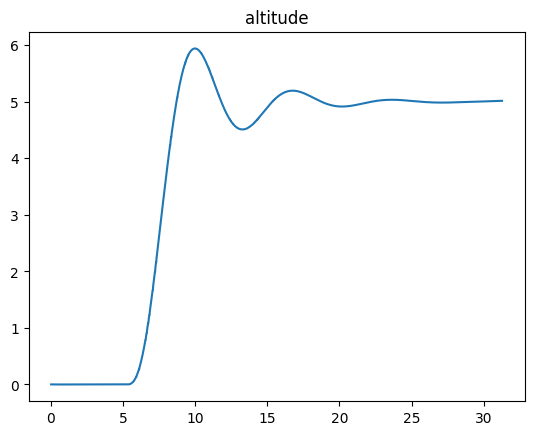

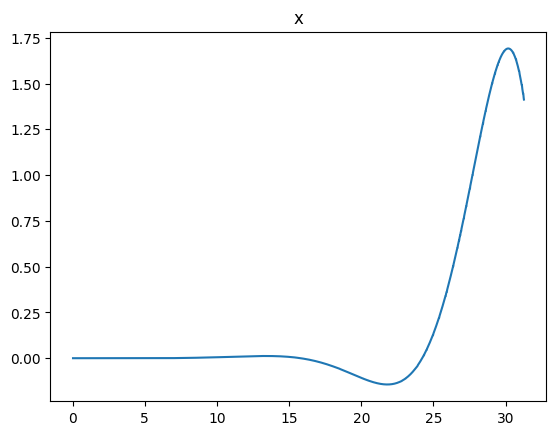

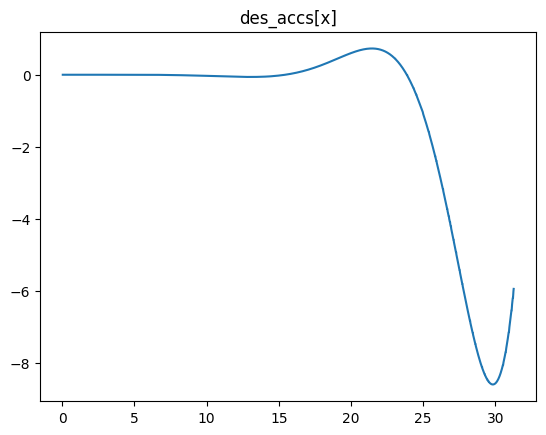

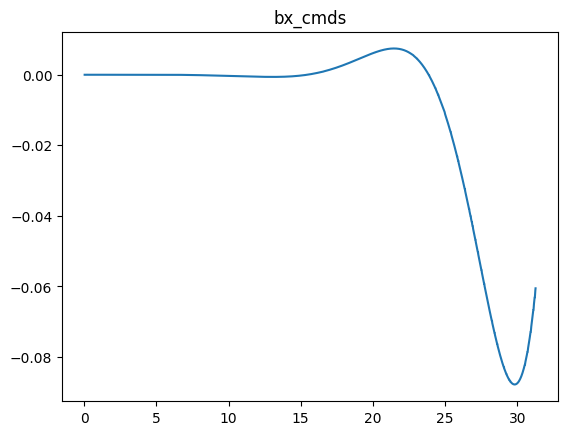

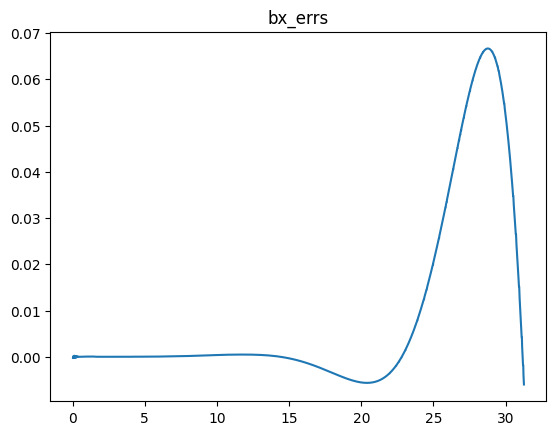

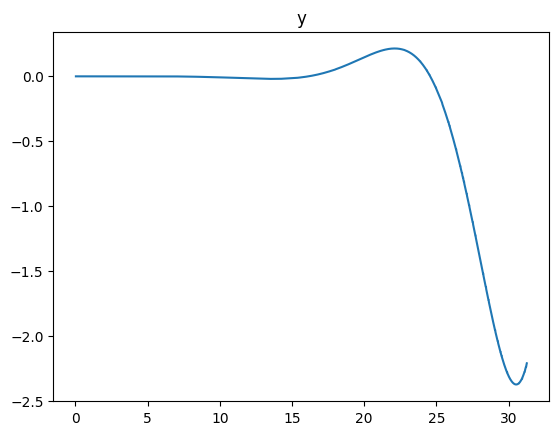

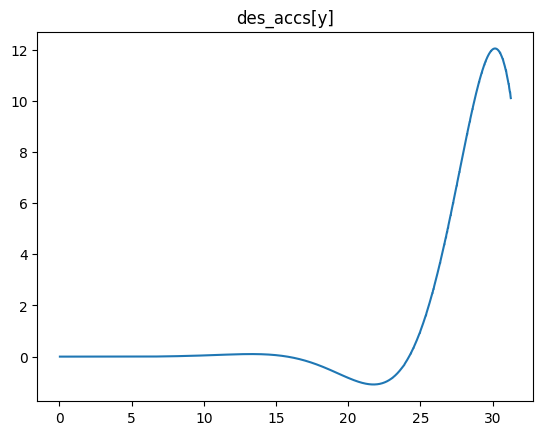

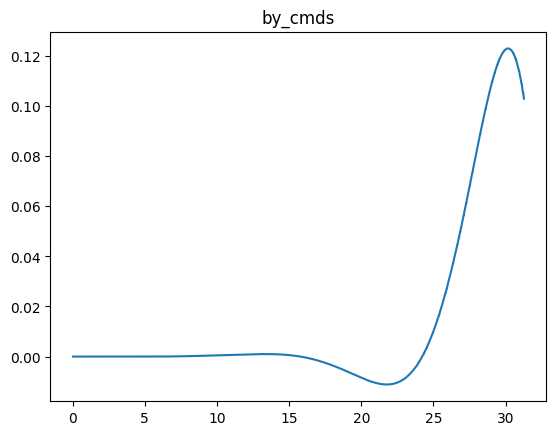

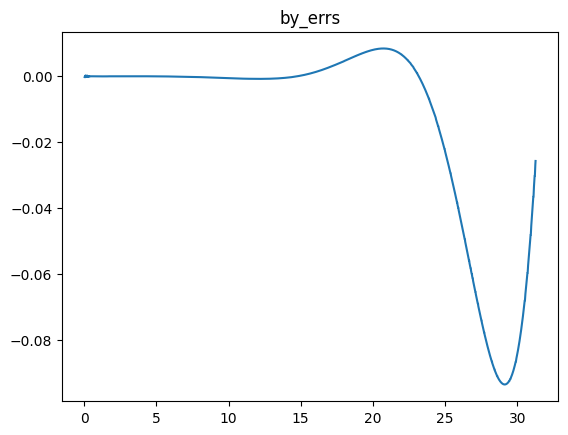

In [38]:
plt.title("altitude")
plt.plot(times, positions[:,2])
plt.show()

plt.title("x")
plt.plot(times, positions[:,0])
plt.show()

plt.title("des_accs[x]")
plt.plot(times, des_accs[:,0])
plt.show()

plt.title("bx_cmds")
plt.plot(times, bx_cmds)
plt.show()

plt.title("bx_errs")
plt.plot(times, bx_errs)
plt.show()

plt.title("y")
plt.plot(times, positions[:,1])
plt.show()

plt.title("des_accs[y]")
plt.plot(times, des_accs[:,1])
plt.show()

plt.title("by_cmds")
plt.plot(times, by_cmds)
plt.show()

plt.title("by_errs")
plt.plot(times, by_errs)
plt.show()





Reference implementation: https://github.com/martin0004/drone_control_system